In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings('ignore')

# Reading the CSV file using the absolute path and converting 'NA' to NaN
file_path = 'C:/Users/User/PycharmProjects/pythonProject11/data/results.csv'
try:
    df = pd.read_csv(file_path, sep=',', na_values='NA')
    print("File read successfully.")
except Exception as e:
    print(f"Error reading the file: {e}")

# Dropping matches without final result
df = df.dropna(subset=['home_score', 'away_score'])
# Dropping useless columns (we will not use neutral for now too, but left for future improvements)
df = df.drop(columns=['city', 'country'])
df['away_deffensive_power'] = 1
df['home_deffensive_power'] = 1
df['away_offensive_power'] = 1
df['home_offensive_power'] = 1


df

File read successfully.


,date,home_team,away_team,home_score,away_score,tournament,neutral,away_deffensive_power,home_deffensive_power,away_offensive_power,home_offensive_power
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,False,1,1,1,1
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,False,1,1,1,1
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,False,1,1,1,1
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,False,1,1,1,1
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,False,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
47262,2024-06-11,Saint Kitts and Nevis,Bahamas,1.0,0.0,FIFA World Cup qualification,False,1,1,1,1
47263,2024-06-11,Saint Lucia,Aruba,2.0,2.0,FIFA World Cup qualification,True,1,1,1,1
47264,2024-06-11,Guyana,Belize,3.0,1.0,FIFA World Cup qualification,True,1,1,1,1
47265,2024-06-11,Dominican Republic,British Virgin Islands,4.0,0.0,FIFA World Cup qualification,False,1,1,1,1


In [2]:
# Auxiliary functions for updating the ratings
confederation_tournaments = ['AFC Asian Cup', 'African Cup of Nations', 'Copa América', 'CONCACAF Championship', 'Oceania Nations Cup']
confederation_clasification = ['African Cup of Nations qualification', 'FC Asian Cup qualification', 'UEFA Nations League']

eurocup_teams = [
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

def calculate_elo(elo_l, elo_v, local_goals, away_goals, tournament):
    k = k_value(tournament)
    wl, wv = actual_result(local_goals, away_goals)
    wel, wev = expected_result(elo_l, elo_v)

    elo_ln = elo_l + k * (wl - wel)
    elo_vn = elo_v + k * (wv - wev)

    return elo_ln, elo_vn, wel, wev


def k_value(tournament):
    k = 5
    if tournament == 'Friendly':
        k = 10
    elif tournament in confederation_clasification:
        k = 20
    elif tournament == 'UEFA Euro qualification' or tournament == 'FIFA World Cup qualification':
        k = 25
    elif tournament == tournament in confederation_tournaments:
        k = 40
    elif tournament == 'UEFA Euro' or tournament == 'FIFA World Cup':
        k = 50
    return k

def actual_result(loc, aw):
    if loc < aw:
        wa = 1
        wl = 0
    elif loc > aw:
        wa = 0
        wl = 1
    elif loc == aw:
        wa = 0.5
        wl = 0.5
    return [wl, wa]

def expected_result(loc, aw):
    dr = loc - aw
    we = (1 / (10**(-dr / 400) + 1))
    return [np.round(we, 3), 1 - np.round(we, 3)]

In [3]:
# Auxiliary functions for updating the ratings
confederation_tournaments = ['AFC Asian Cup', 'African Cup of Nations', 'Copa América', 'CONCACAF Championship', 'Oceania Nations Cup']
confederation_clasification = ['African Cup of Nations qualification', 'FC Asian Cup qualification', 'UEFA Nations League']

eurocup_teams = [
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

def actual_result(loc, aw):
    if loc < aw:
        wa = 1
        wl = 0
    elif loc > aw:
        wa = 0
        wl = 1
    elif loc == aw:
        wa = 0.5
        wl = 0.5
    return [wl, wa]

def expected_result(loc, aw):
    dr = loc - aw
    we = (1 / (10**(-dr / 400) + 1))
    return [np.round(we, 3), 1 - np.round(we, 3)]

def calculate_elo(elo_l, elo_v, local_goals, away_goals, tournament):
    k = k_value(tournament)
    wl, wv = actual_result(local_goals, away_goals)
    wel, wev = expected_result(elo_l, elo_v)

    elo_ln = elo_l + k * (wl - wel)
    elo_vn = elo_v + k * (wv - wev)

    return elo_ln, elo_vn, wel, wev


def k_value(tournament):
    k = 5
    if tournament == 'Friendly':
        k = 10
    elif tournament in confederation_clasification:
        k = 20
    elif tournament == 'UEFA Euro qualification' or tournament == 'FIFA World Cup qualification':
        k = 25
    elif tournament == tournament in confederation_tournaments:
        k = 40
    elif tournament == 'UEFA Euro' or tournament == 'FIFA World Cup':
        k = 50
    return k

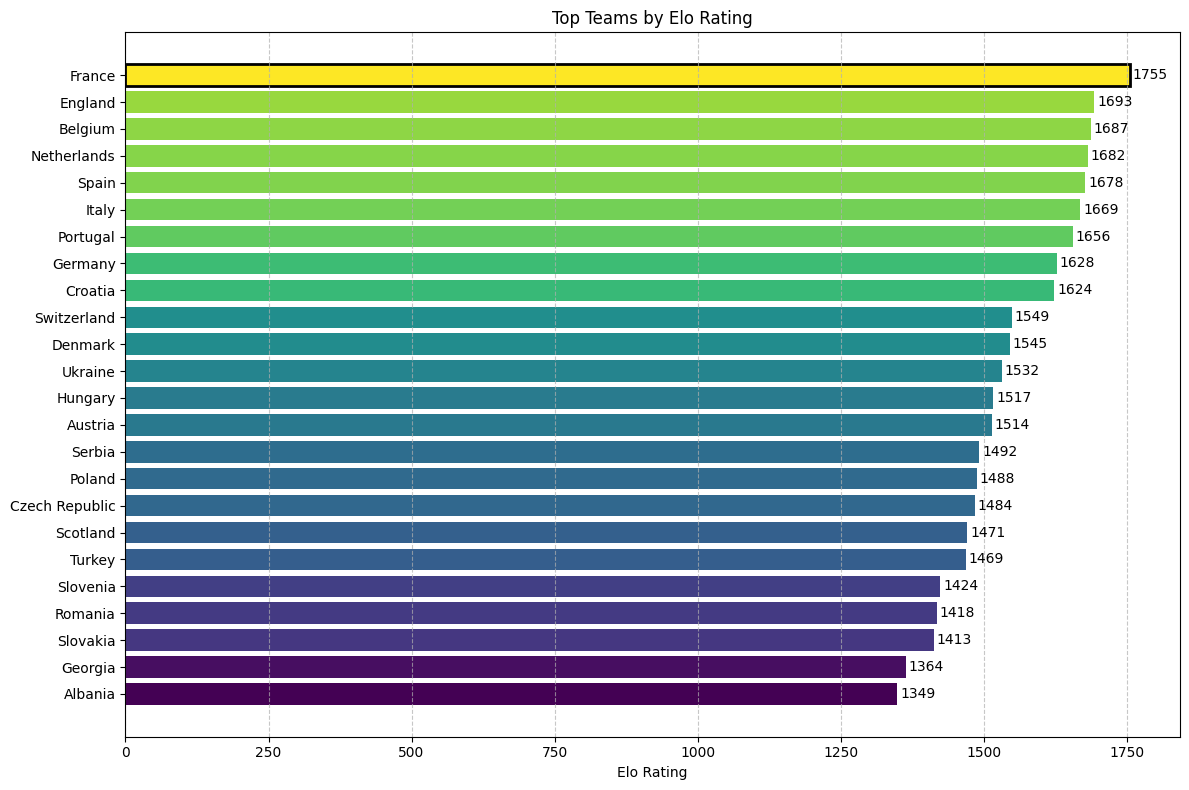

In [4]:
current_elo = {}


for idx, row in df.iterrows():
    local = row['home_team']
    away = row['away_team']
    local_goals = row['home_score']
    away_goals = row['away_score']
    tournament = row['tournament']
    match_date = pd.to_datetime(row['date'])


    if local not in current_elo.keys():
        current_elo[local] = 1300

    if away not in current_elo.keys():
        current_elo[away] = 1300

    elo_l = current_elo[local]
    elo_v = current_elo[away]
    
    elo_ln, elo_vn, wel, wev = calculate_elo(elo_l, elo_v, local_goals, away_goals, tournament)

    current_elo[local] = elo_ln
    current_elo[away] = elo_vn

    df.loc[idx, 'Elo_h_after'] = elo_ln
    df.loc[idx, 'Elo_a_after'] = elo_vn
    df.loc[idx, 'elo_diff'] = elo_l - elo_v
    df.loc[idx, 'Elo_h_before'] = elo_l
    df.loc[idx, 'Elo_a_before'] = elo_v
    df.loc[idx, 'probH'] = wel
    df.loc[idx, 'probA'] = wev


elos = pd.concat([df[['date', 'home_team', 'Elo_h_after']].rename(columns={'home_team': 'Team', 'Elo_h_after': 'Elo'}),
                  df[['date', 'away_team', 'Elo_a_after']].rename(columns={'away_team': 'Team', 'Elo_a_after': 'Elo'})])
elos.sort_values(by='date', ascending=False, inplace=True)
elos.drop_duplicates('Team', inplace=True)
elos.sort_values(by='Elo', ascending=False, inplace=True)
elos.reset_index(drop=True, inplace=True)
elos['position'] = elos.index + 1

def plot_top_elo(elos, n=10):
    """
    Plots the top n teams by Elo rating in a horizontal bar chart.

    Parameters:
    elos (pd.DataFrame): DataFrame containing 'Team' and 'Elo' columns.
    n (int): Number of top teams to display.
    """
    # Sort elos DataFrame by Elo rating in descending order
    elos.sort_values(by='Elo', ascending=False, inplace=True)

    # Select only the top n teams
    top_teams = elos.head(n)

    # Create a color map
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=min(top_teams['Elo']), vmax=max(top_teams['Elo']))
    colors = cmap(norm(top_teams['Elo']))

    # Plotting
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_teams['Team'], top_teams['Elo'], color=colors)

    # Add text annotations
    for bar in bars:
        plt.text(
            bar.get_width() + 5,
            bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.0f}',
            ha='left',
            va='center',
            fontsize=10
        )

    # Highlighting the top team
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(2)

    # Customizing the plot
    plt.xlabel('Elo Rating')
    plt.title('Top Teams by Elo Rating')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest Elo at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

elos_ranking_euro = elos[elos.Team.isin(eurocup_teams)].copy()
plot_top_elo(elos_ranking_euro, 24)

In [5]:
# Function to calculate time-based weight linearly
def calculate_weight(date, current_date, tournament, start_weight=1.0, end_weight=0, years=30):
    k = 1 - k_value(tournament)/100
    days_diff = (current_date - date).days
    total_days = years * 365
    weight = start_weight - (start_weight - end_weight) * (days_diff / total_days) * k 
    return max(weight, end_weight)

df2 = df[df['date'] >= '1994-06-13']
goal_stats = pd.DataFrame(columns=[
    'team', 
    'total_weighted_goals', 
    'total_weighted_matches', 
    'total_weighted_goals_against', 
    'scored',
    'elo_diff'
])
current_date = pd.to_datetime('today')

for idx, row in df2.iterrows():
    local = row['home_team']
    away = row['away_team']
    local_goals = row['home_score']
    away_goals = row['away_score']
    tournament = row['tournament']
    home_elo = row['Elo_h_before']
    away_elo = row['Elo_a_before']
    match_date = pd.to_datetime(row['date'])
    elo_diff = row['elo_diff']

    weight = calculate_weight(match_date, current_date, tournament)
    

    if local not in goal_stats.index:
        goal_stats.loc[local] = [local, 
                                 local_goals * weight * away_elo / 1300, 
                                 weight, 
                                 away_goals * weight * home_elo / 1300, 
                                 [local_goals],
                                 [elo_diff]]
    else:
        goal_stats.at[local, 'total_weighted_goals'] += local_goals * weight * away_elo / home_elo
        goal_stats.at[local, 'total_weighted_matches'] += weight
        goal_stats.at[local, 'total_weighted_goals_against'] += away_goals * weight * home_elo / away_elo
        goal_stats.at[local, 'scored'].append(local_goals)
        goal_stats.at[local, 'elo_diff'].append(elo_diff)

    if away not in goal_stats.index:
        goal_stats.loc[away] = [away, 
                                away_goals * weight * home_elo / away_elo, 
                                weight, 
                                local_goals * weight * away_elo / home_elo, 
                                [away_goals],
                                [elo_diff]]
    else:
        goal_stats.at[away, 'total_weighted_goals'] += away_goals * weight * home_elo / away_elo
        goal_stats.at[away, 'total_weighted_matches'] += weight
        goal_stats.at[away, 'total_weighted_goals_against'] += local_goals * weight * away_elo / home_elo
        goal_stats.at[away, 'scored'].append(away_goals)
        goal_stats.at[away, 'elo_diff'].append(elo_diff)

    #df2['weight'] = weight
    df2.loc[idx, 'away_deffensive_power'] = goal_stats.at[away, 'total_weighted_goals_against'] / goal_stats.at[away, 'total_weighted_matches']
    df2.loc[idx, 'home_deffensive_power'] = goal_stats.at[local, 'total_weighted_goals_against'] / goal_stats.at[local, 'total_weighted_matches']
    df2.loc[idx, 'away_offensive_power'] = goal_stats.at[away, 'total_weighted_goals'] / goal_stats.at[away, 'total_weighted_matches']
    df2.loc[idx, 'home_offensive_power'] = goal_stats.at[local, 'total_weighted_goals'] / goal_stats.at[local, 'total_weighted_matches']

    #if local == 'England':
    #    print(goal_stats.at[away, 'total_weighted_goals_against'] / goal_stats.at[away, 'total_weighted_matches'])
    #    print(df2['away_deffensive_power'])

Team: Albania, Weighted Avg Goals: 1.0739234011365126, Weighted Avg Lost Goals: 1.0838625016310226
Team: Scotland, Weighted Avg Goals: 1.2030538003329305, Weighted Avg Lost Goals: 1.180513095696267
Team: Hungary, Weighted Avg Goals: 1.3292783901471905, Weighted Avg Lost Goals: 1.192709241599633
Team: Romania, Weighted Avg Goals: 1.3684211923506722, Weighted Avg Lost Goals: 1.0314487876476572
Team: Germany, Weighted Avg Goals: 1.881507461167555, Weighted Avg Lost Goals: 1.1613044023937822
Team: Slovakia, Weighted Avg Goals: 1.3317571956589043, Weighted Avg Lost Goals: 1.1268507139305082
Team: England, Weighted Avg Goals: 1.6797917244025722, Weighted Avg Lost Goals: 0.8014175326514861
Team: Czech Republic, Weighted Avg Goals: 1.5146277873214065, Weighted Avg Lost Goals: 1.0765161845493383
Team: Austria, Weighted Avg Goals: 1.4553789055823565, Weighted Avg Lost Goals: 1.1995945914396418
Team: Slovenia, Weighted Avg Goals: 1.2226607841964123, Weighted Avg Lost Goals: 1.0717055919225458
Tea

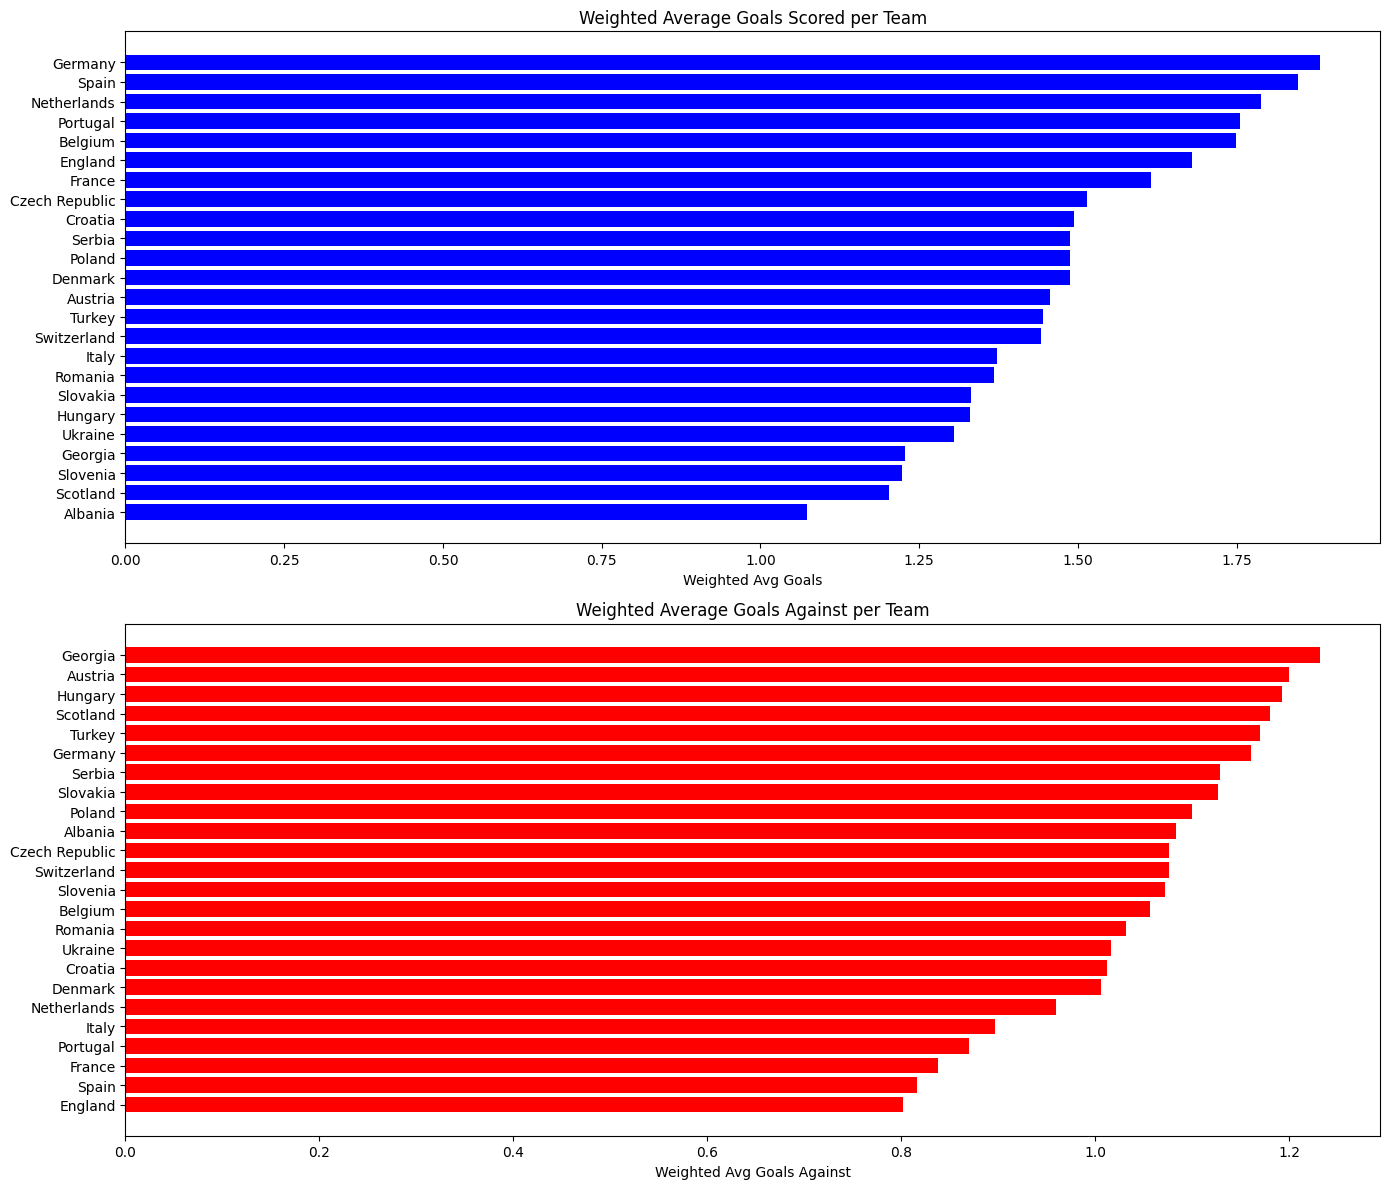

In [6]:
weighted_goals = {}
weighted_goals_against = {}

for team in eurocup_teams:
    if team in goal_stats.index:
        stats = goal_stats.loc[team]
        weighted_goals[team] = stats['total_weighted_goals'] / stats['total_weighted_matches']
        weighted_goals_against[team] = stats['total_weighted_goals_against'] / stats['total_weighted_matches']
        print(f"Team: {team}, Weighted Avg Goals: {weighted_goals[team]}, Weighted Avg Lost Goals: {weighted_goals_against[team]}")

# Create dataframes
weighted_goals_df = pd.DataFrame(list(weighted_goals.items()), columns=['Team', 'Weighted Avg Goals'])
weighted_goals_against_df = pd.DataFrame(list(weighted_goals_against.items()), columns=['Team', 'Weighted Avg Goals Against'])

# Sort dataframes
weighted_goals_df = weighted_goals_df.sort_values(by='Weighted Avg Goals', ascending=False)
weighted_goals_against_df = weighted_goals_against_df.sort_values(by='Weighted Avg Goals Against', ascending=False)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

# Plot weighted average goals
axes[0].barh(weighted_goals_df['Team'], weighted_goals_df['Weighted Avg Goals'], color='blue')
axes[0].set_xlabel('Weighted Avg Goals')
axes[0].set_title('Weighted Average Goals Scored per Team')
axes[0].invert_yaxis()

# Plot weighted average goals against
axes[1].barh(weighted_goals_against_df['Team'], weighted_goals_against_df['Weighted Avg Goals Against'], color='red')
axes[1].set_xlabel('Weighted Avg Goals Against')
axes[1].set_title('Weighted Average Goals Against per Team')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [7]:
df2
df2.loc[idx, 'elo_diff'] = elo_l - elo_v

In [8]:
matches_data = [
    # Grupo A
    {"Grupo": "A", "Home_Team": "Germany", "Away_Team": "Scotland"},
    {"Grupo": "A", "Home_Team": "Hungary", "Away_Team": "Switzerland"},
    {"Grupo": "A", "Home_Team": "Germany", "Away_Team": "Hungary"},
    {"Grupo": "A", "Home_Team": "Scotland", "Away_Team": "Switzerland"},
    {"Grupo": "A", "Home_Team": "Switzerland", "Away_Team": "Germany"},
    {"Grupo": "A", "Home_Team": "Scotland", "Away_Team": "Hungary"},
    # Grupo B
    {"Grupo": "B", "Home_Team": "Spain", "Away_Team": "Croatia"},
    {"Grupo": "B", "Home_Team": "Italy", "Away_Team": "Albania"},
    {"Grupo": "B", "Home_Team": "Croatia", "Away_Team": "Albania"},
    {"Grupo": "B", "Home_Team": "Spain", "Away_Team": "Italy"},
    {"Grupo": "B", "Home_Team": "Albania", "Away_Team": "Spain"},
    {"Grupo": "B", "Home_Team": "Croatia", "Away_Team": "Italy"},
    # Grupo C
    {"Grupo": "C", "Home_Team": "Slovenia", "Away_Team": "Denmark"},
    {"Grupo": "C", "Home_Team": "Serbia", "Away_Team": "England"},
    {"Grupo": "C", "Home_Team": "Slovenia", "Away_Team": "Serbia"},
    {"Grupo": "C", "Home_Team": "Denmark", "Away_Team": "England"},
    {"Grupo": "C", "Home_Team": "England", "Away_Team": "Slovenia"},
    {"Grupo": "C", "Home_Team": "Denmark", "Away_Team": "Serbia"},
    # Grupo D
    {"Grupo": "D", "Home_Team": "Poland", "Away_Team": "Netherlands"},
    {"Grupo": "D", "Home_Team": "Austria", "Away_Team": "France"},
    {"Grupo": "D", "Home_Team": "Poland", "Away_Team": "Austria"},
    {"Grupo": "D", "Home_Team": "Netherlands", "Away_Team": "France"},
    {"Grupo": "D", "Home_Team": "Netherlands", "Away_Team": "Austria"},
    {"Grupo": "D", "Home_Team": "France", "Away_Team": "Poland"},
    # Grupo E
    {"Grupo": "E", "Home_Team": "Romania", "Away_Team": "Ukraine"},
    {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Slovakia"},
    {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Ukraine"},
    {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Romania"},
    {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Romania"},
    {"Grupo": "E", "Home_Team": "Ukraine", "Away_Team": "Belgium"},
    # Grupo F
    {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Georgia"},
    {"Grupo": "F", "Home_Team": "Portugal", "Away_Team": "Czech Republic"},
    {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Czech Republic"},
    {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Portugal"},
    {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Portugal"},
    {"Grupo": "F", "Home_Team": "Czech Republic", "Away_Team": "Turkey"},
]

# Create a dataframe
matches_df = pd.DataFrame(matches_data)

2.7682979959337786 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]


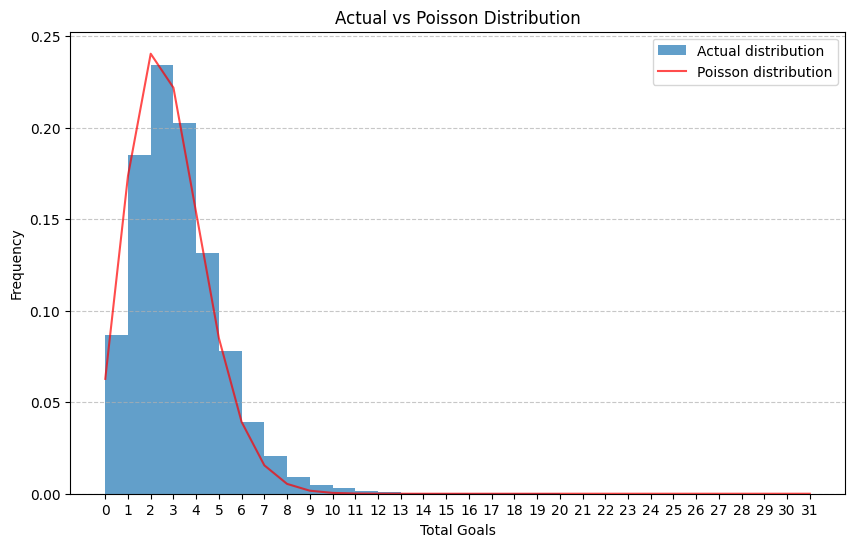

In [9]:
import matplotlib.pyplot as plt

# Calculate total goals for each match
df2['total_goals'] = df2['home_score'] + df2['away_score']

mu = df2['total_goals'].mean()
k = np.arange(0, df2['total_goals'].max()+1)
poisson_pmf = poisson.pmf(k, mu)
print(mu, k)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df2['total_goals'], bins=k, density=True, alpha=0.7, label='Actual distribution')
#plt.hist(df2['total_goals'], bins=range(int(df2['total_goals'].max()) + 2), edgecolor='black', align='left')
plt.title('Actual vs Poisson Distribution')
plt.plot(k, poisson_pmf, 'r-', alpha=0.7, label='Poisson distribution')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.xticks(range(int(df2['total_goals'].max()) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

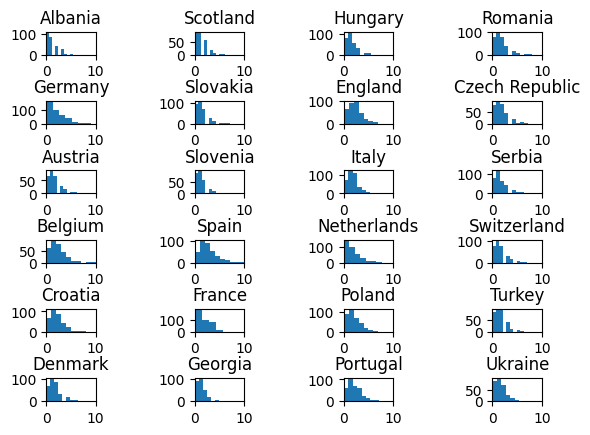

In [10]:
figure, axis = plt.subplots(6, 4)
figure.subplots_adjust(hspace=2, wspace=2)
counter = 0
plt.title("Histogram of Goals Scored")
for i in range(6):
    for j in range(4):
        team = eurocup_teams[counter]
        stats = goal_stats.loc[team]
        #print(team, goal_stats[f"{team}"]['scored'])
        axis[i, j].set_title(f"{team}")
        axis[i, j].hist(stats['scored'])
        axis[i, j].set_xlim(0, 10)
        counter += 1

In [11]:
def get_elo_value(team_name):
    # Check if the team exists in the DataFrame
    if team_name in elos_ranking_euro['Team'].values:
        # Retrieve the Elo value for the given team
        elo_value = elos_ranking_euro.loc[elos_ranking_euro['Team'] == team_name, 'Elo'].values[0]
        return elo_value
        
print(get_elo_value('France'))

1755.4349999999997


In [12]:
df3 = df2[['home_score', 'away_score', 'elo_diff', 'home_deffensive_power', 'away_deffensive_power', 'home_offensive_power', 'away_offensive_power']]

In [13]:
df3

,home_score,away_score,elo_diff,home_deffensive_power,away_deffensive_power,home_offensive_power,away_offensive_power
19723,1.0,0.0,282.105,0.000000,0.822828,1.007815,0.000000
19724,2.0,2.0,53.960,2.326323,1.928630,2.243308,2.074012
19725,1.0,3.0,30.940,3.442396,0.979259,1.123665,3.063542
19726,0.0,1.0,112.185,1.228023,0.000000,0.000000,1.075584
19727,1.0,1.0,-122.385,1.010869,1.093130,1.105012,0.914804
...,...,...,...,...,...,...,...
47262,1.0,0.0,52.945,1.531343,2.839630,1.479421,1.123123
47263,2.0,2.0,17.345,1.747452,2.046538,1.335604,1.378826
47264,3.0,1.0,5.355,1.528194,1.719532,1.638385,1.007181
47265,4.0,0.0,133.695,1.404241,3.065568,1.639478,0.873252


0.020021031650516607
[[0.00097954]] [0.15851769]


array([[-0.23232018]])

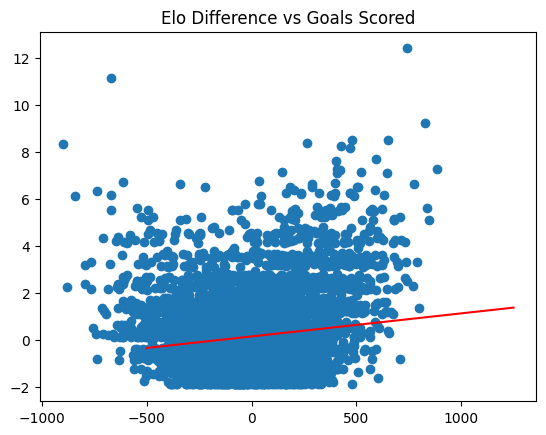

In [14]:
# Initialize mega as a list of two empty lists
mega = [[], []]

# Iterate over the rows of the goal_stats DataFrame
for idx, row in goal_stats.iterrows():
    if idx in eurocup_teams:
        #print(row)
        team = row['team']
        scored_goals = np.array(row['scored'])
        weighted_goal_avg = weighted_goals[team]
        
        mega[1] += (scored_goals - np.array(len(scored_goals) * [weighted_goal_avg])).tolist()

        #print(row['elo_diff'])
        mega[0] += row['elo_diff']


from sklearn.linear_model import LinearRegression

X, y = np.array(mega[0]).reshape(-1, 1), np.array(mega[1]).reshape(-1, 1)
reg = LinearRegression()
reg.fit(X, y)
print(reg.score(X, y))
print(reg.coef_, reg.intercept_)

plt.title('Elo Difference vs Goals Scored')
plt.scatter(mega[0], mega[1])
x = np.arange(-500, 1250)
y = x*reg.coef_[0] + reg.intercept_[0]
plt.plot(x, y, color='red')

reg.predict(np.array([-399]).reshape(-1,1))


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df3 is already defined with the necessary data

# Split the data into training and test sets
train_df, test_df = train_test_split(df3, test_size=0.2, random_state=42)

# Apply the scaler to the feature columns only (excluding target columns)
X_train = train_df.drop(columns=['home_score', 'away_score', 'elo_diff'])
X_test = test_df.drop(columns=['home_score', 'away_score', 'elo_diff'])


# Convert the scaled arrays back to DataFrames

y_train = train_df[['home_score', 'away_score']]

#print(X_train)

#print(train_df_scaled)
#print(test_df_scaled)

# Separate features and targets
#X_test_final = test_df_scaled.drop(columns=['home_score', 'away_score'])
#y_test_final = test_df_scaled[['home_score', 'away_score']]

# Function to transform features for model input
def transform_x(df):
    home_df = df[['home_offensive_power', 'away_deffensive_power']].copy()
    home_df.columns = ['offensive_power', 'deffensive_power']
    
    away_df = df[['away_offensive_power', 'home_deffensive_power']].copy()
    away_df.columns = ['offensive_power', 'deffensive_power']
    
    new_df = pd.concat([home_df, away_df], ignore_index=True)
    return new_df

# Function to transform targets for model input
def transform_y(df):
    home_df = df[['home_score']].copy()
    home_df.columns = ['team_score']
    
    away_df = df[['away_score']].copy()
    away_df.columns = ['team_score']
    
    new_df = pd.concat([home_df, away_df], ignore_index=True)
    return new_df

# Apply transformations
X_train_final = transform_x(X_train)
y_train_final = transform_y(y_train)


# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize model
model = PoissonRegressor()

# Cross-validation scores

# print(X_train_final)
# print(y_train_final)

cv_score = cross_val_score(model, X_train_final, y_train_final, cv=kf, scoring='neg_mean_absolute_error')
print(f'Cross-Validation Score (MAE): {-cv_score.mean()}')

# Train model

print(X_train_final)
print(y_train_final)
model.fit(X_train_final, y_train_final)

# Function to predict match outcomes
def predict_match(home_off_power, away_off_power, home_def_power, away_def_power):
    # Create feature arrays for both teams
    features_home = np.array([[home_off_power, away_def_power]])
    features_away = np.array([[away_off_power, home_def_power]])
    
    # Predict goals
    predicted_home_goals = model.predict(features_home)
    predicted_away_goals = model.predict(features_away)
    
    return predicted_home_goals[0], predicted_away_goals[0]

Cross-Validation Score (MAE): 1.0738689283606386
       offensive_power  deffensive_power
0             1.091889          1.165417
1             1.435780          1.882117
2             1.235996          1.114759
3             1.665624          1.164877
4             1.688104          1.027856
...                ...               ...
44065         0.715248          0.891242
44066         1.004118          1.233044
44067         1.255205          1.626356
44068         0.000000          1.392553
44069         0.954056          1.221077

[44070 rows x 2 columns]
       team_score
0             3.0
1             5.0
2             3.0
3             1.0
4             1.0
...           ...
44065         1.0
44066         0.0
44067         1.0
44068         0.0
44069         1.0

[44070 rows x 1 columns]


In [34]:
# Function to check accuracy of predictions
def accuracy_check(df):
    matches_number = 0
    exact_result = 0
    correct_outcome = 0
    for idx, row in df.iterrows():
        matches_number += 1

        elo_diff = row['elo_diff']
        home_off_power = row['home_offensive_power']
        away_off_power = row['away_offensive_power']
        home_def_power = row['home_deffensive_power']
        away_def_power = row['away_deffensive_power']
        home_score = row['home_score']
        away_score = row['away_score']
        
        home_pred, away_pred = predict_match(home_off_power, away_off_power, home_def_power, away_def_power)
        #print(home_pred, away_pred)
        
        home_pred = home_pred + reg.predict(np.array([elo_diff]).reshape(-1,1))[0]
        away_pred = away_pred - reg.predict(np.array([elo_diff]).reshape(-1,1))[0]
        #print(home_pred, '-', away_pred)
        #print("")
        
        # Predict the most likely score using the Poisson distribution
        max_goals = 10
        home_goals_prob = [poisson.pmf(i, home_pred) for i in range(max_goals + 1)]
        away_goals_prob = [poisson.pmf(i, away_pred) for i in range(max_goals + 1)]

        
        most_likely_home_goals = np.argmax(home_goals_prob)
        most_likely_away_goals = np.argmax(away_goals_prob)

        print(most_likely_home_goals, '-', most_likely_away_goals, ' where should be ', home_score, '-', away_score)

        if home_score == most_likely_home_goals and away_score == most_likely_away_goals:
            exact_result += 1

        if home_score > away_score:
            result = 1.0
        elif home_score < away_score:
            result = 0.0
        else:
            result = 0.5

        if home_pred > away_pred:
            prediction = 1.0
        elif home_pred < away_pred:
            prediction = 0.0
        else:
            prediction = 0.5

        if result == prediction:
            correct_outcome += 1

    print('Accuracy of exact scores: ', exact_result / matches_number)
    print('Accuracy of correct outcome: ', correct_outcome / matches_number)

#print(test_df)
# Check accuracy on the test set
accuracy_check(test_df)

1 - 0  where should be  2.0 - 2.0
1 - 0  where should be  2.0 - 1.0
1 - 1  where should be  0.0 - 1.0
1 - 0  where should be  0.0 - 1.0
1 - 0  where should be  1.0 - 0.0
10 - 0  where should be  11.0 - 0.0
1 - 1  where should be  0.0 - 2.0
1 - 1  where should be  3.0 - 1.0
1 - 1  where should be  1.0 - 0.0
1 - 1  where should be  1.0 - 2.0
1 - 2  where should be  0.0 - 2.0
2 - 0  where should be  4.0 - 1.0
1 - 1  where should be  0.0 - 2.0
1 - 1  where should be  1.0 - 0.0
1 - 1  where should be  0.0 - 2.0
1 - 1  where should be  0.0 - 1.0
1 - 0  where should be  4.0 - 1.0
1 - 1  where should be  2.0 - 0.0
1 - 1  where should be  1.0 - 0.0
2 - 1  where should be  2.0 - 1.0
2 - 0  where should be  7.0 - 0.0
1 - 1  where should be  3.0 - 2.0
1 - 1  where should be  1.0 - 3.0
1 - 1  where should be  3.0 - 1.0
1 - 0  where should be  1.0 - 1.0
1 - 1  where should be  1.0 - 3.0
2 - 1  where should be  1.0 - 0.0
1 - 1  where should be  0.0 - 4.0
1 - 1  where should be  1.0 - 3.0
1 - 1  where

In [51]:
# Function to predict the exact score based on team names
def predict_match_xG(home_team, away_team):
    home_elo = get_elo_value(home_team)
    away_elo = get_elo_value(away_team)
    elo_diff = home_elo - away_elo
    home_off_power = weighted_goals.get(home_team, 1.0)  # Default value if team not found
    away_off_power = weighted_goals.get(away_team, 1.0)
    home_def_power = weighted_goals_against.get(home_team, 1.0)
    away_def_power = weighted_goals_against.get(away_team, 1.0)

    #print('before scaling: ', features['elo_diff'][0])
    #print('after scaling: ', scaled_features['elo_diff'][0])
    #print('reversed scaling: ', scaler.inverse_transform(-scaled_features['elo_diff'][0]))
    #print(scaled_features)
    


    #print(scaled_elo_diff_home[0], scaled_home_off_power[0], scaled_away_off_power[0], scaled_home_def_power[0], scaled_away_def_power[0])

    home_pred, away_pred = predict_match(home_off_power, away_off_power, home_def_power, away_def_power)

    home_pred = home_pred + reg.predict(np.array([elo_diff]).reshape(-1,1))
    away_pred = away_pred - reg.predict(np.array([elo_diff]).reshape(-1,1))
    return home_pred[0][0], away_pred[0][0]

# Example usage
home_team = 'Spain'
away_team = 'Georgia'

home_pred, away_pred = predict_match_xG(home_team, away_team)

# elo_diff =  get_elo_value(home_team) -  get_elo_value(away_team)

# home_pred = home_pred + reg.predict(np.array([elo_diff]).reshape(-1,1))[0][0]
# away_pred = away_pred + reg.predict(np.array([-elo_diff]).reshape(-1,1))[0][0]

#home_pred = np.round(home_pred).astype(int)
#away_pred = np.round(away_pred).astype(int)
#predict_exact_score(home_team, away_team)
print(f'Predicted score for {home_team} vs {away_team}: {home_pred} - {away_pred}')

Predicted score for Spain vs Georgia: 1.8582175997715566 - 0.7351566606177097


1.8582175997715566 0.7351566606177097


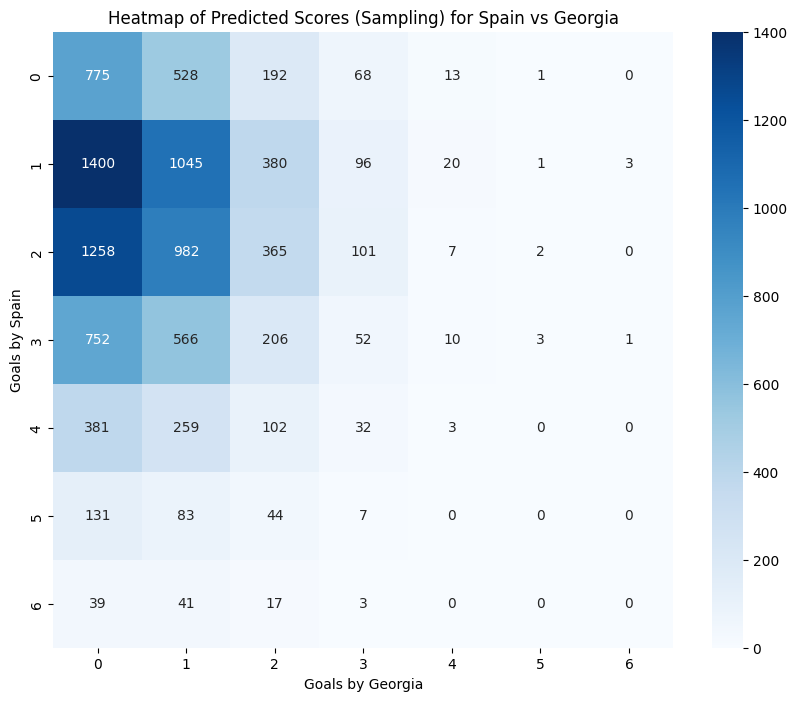

In [52]:
import seaborn as sns
# Function to sample scores from Poisson distribution
def sample_poiss(l, n):
    max_goals = 100
    p = [poisson.pmf(x, l) for x in range(max_goals)]
    return np.random.choice(range(max_goals), n, p=p)


# Function to generate heatmap using sampled scores with exact counts
def generate_heatmap_sampling(home_team, away_team, xG_home, xG_away, n_samples=10000):
    max_goals = 6
    home_goals_samples = sample_poiss(xG_home, n_samples)
    away_goals_samples = sample_poiss(xG_away, n_samples)
    
    joint_prob_matrix = np.zeros((max_goals + 1, max_goals + 1))
    
    for hg, ag in zip(home_goals_samples, away_goals_samples):
        if hg <= max_goals and ag <= max_goals:
            joint_prob_matrix[hg, ag] += 1
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(joint_prob_matrix, annot=True, cmap="Blues", fmt=".0f",
                xticklabels=range(max_goals + 1), yticklabels=range(max_goals + 1))
    plt.xlabel(f'Goals by {away_team}')
    plt.ylabel(f'Goals by {home_team}')
    plt.title(f'Heatmap of Predicted Scores (Sampling) for {home_team} vs {away_team}')
    plt.show()

xG_home, xG_away = predict_match_xG('Spain', 'Georgia')
print(xG_home, xG_away)
generate_heatmap_sampling('Spain', 'Georgia', xG_home, xG_away)

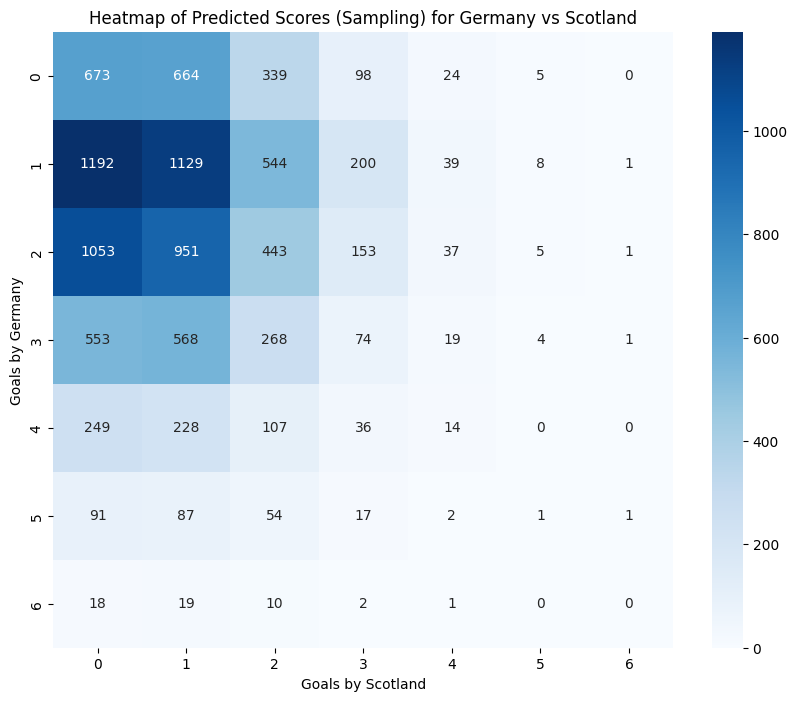

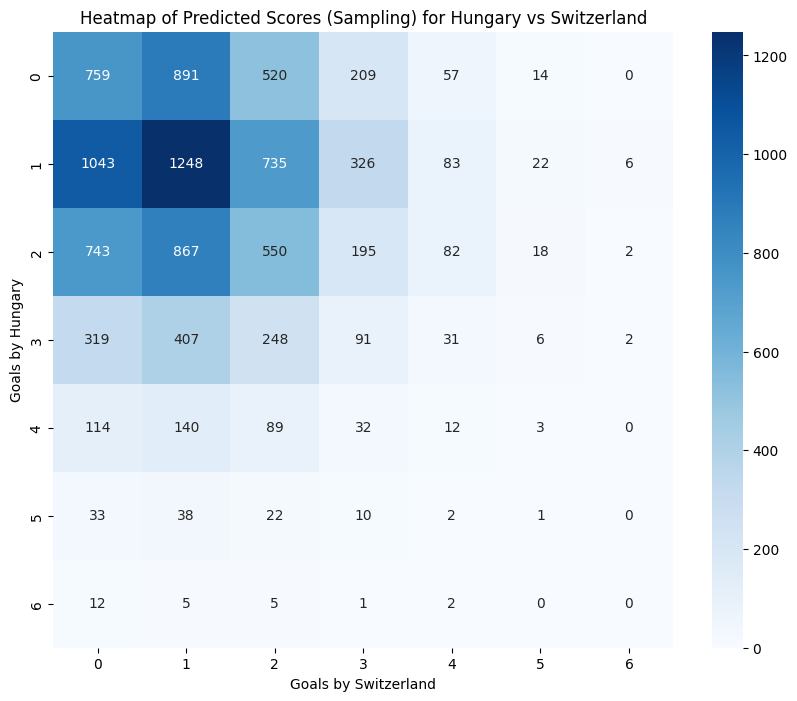

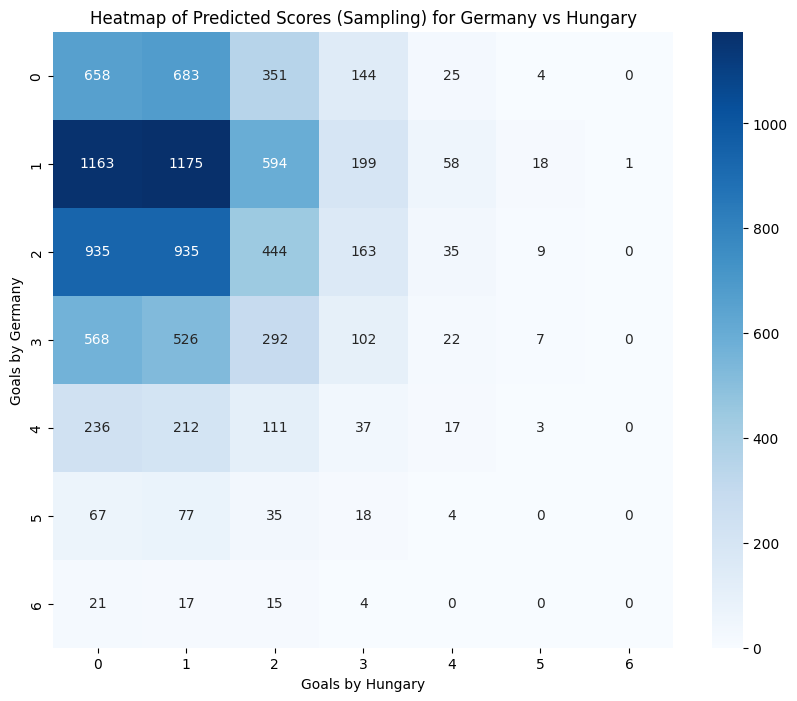

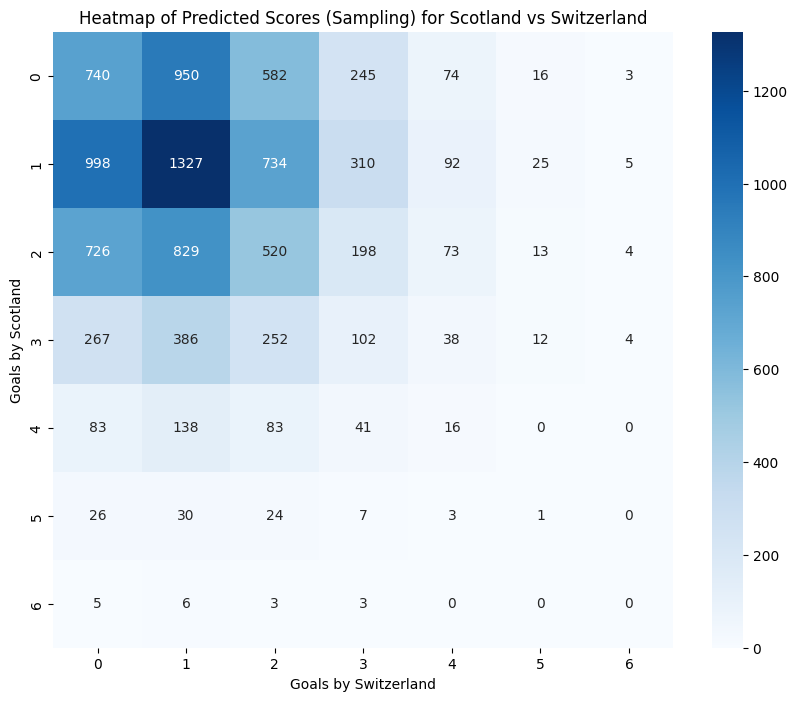

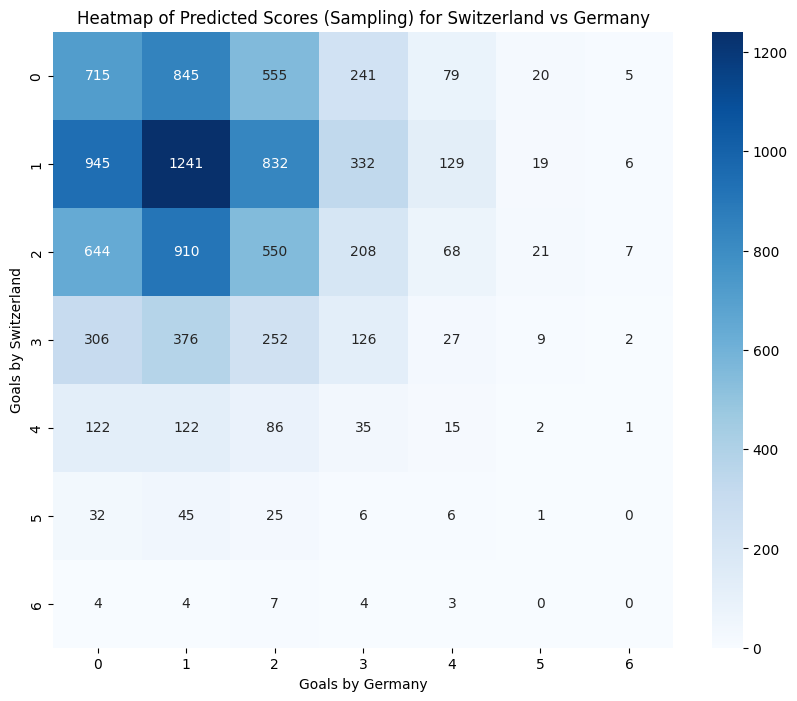

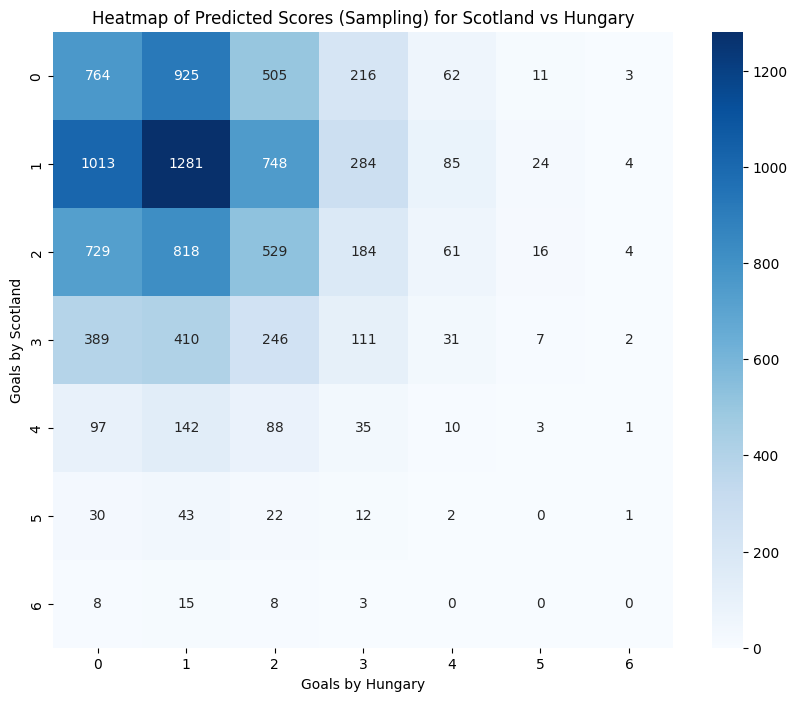

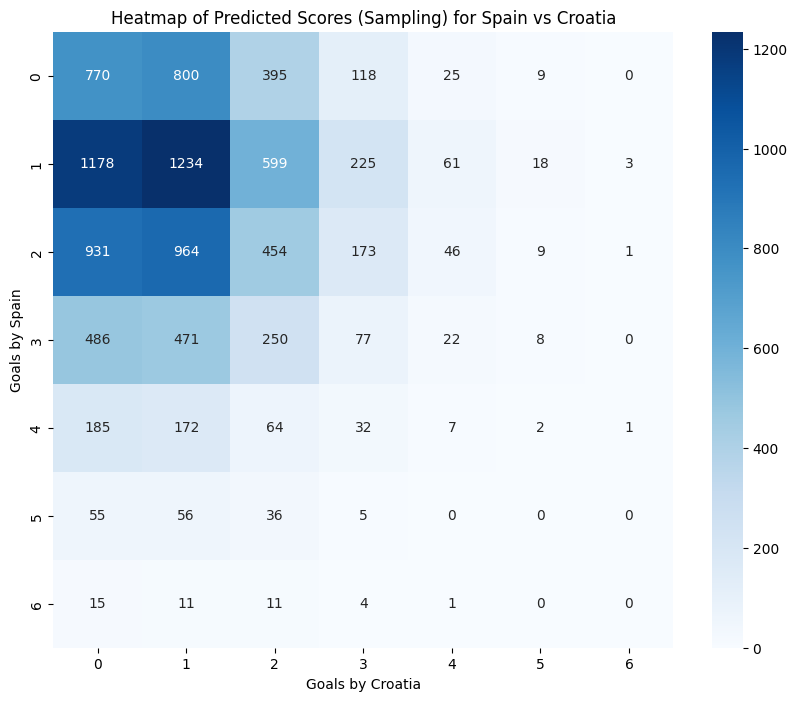

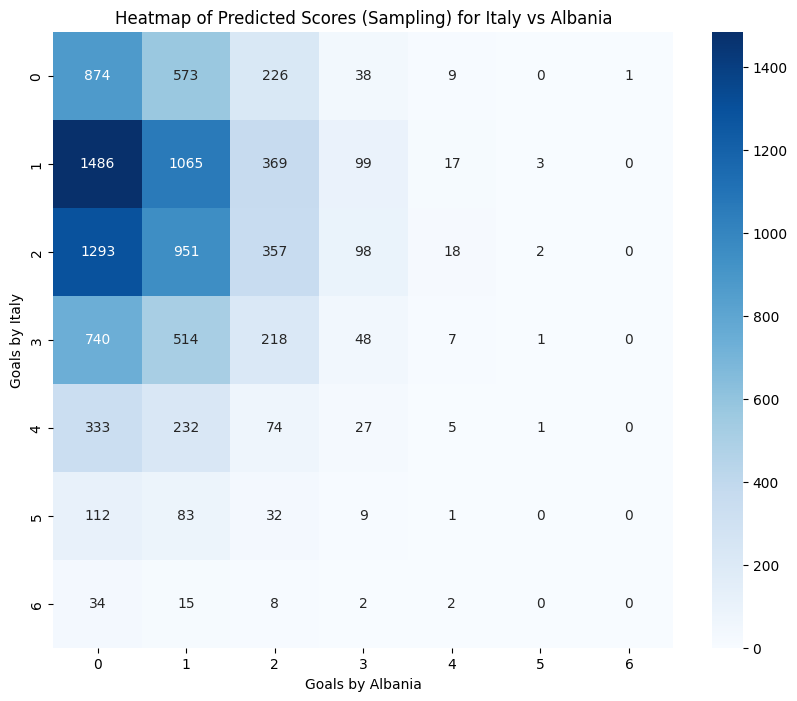

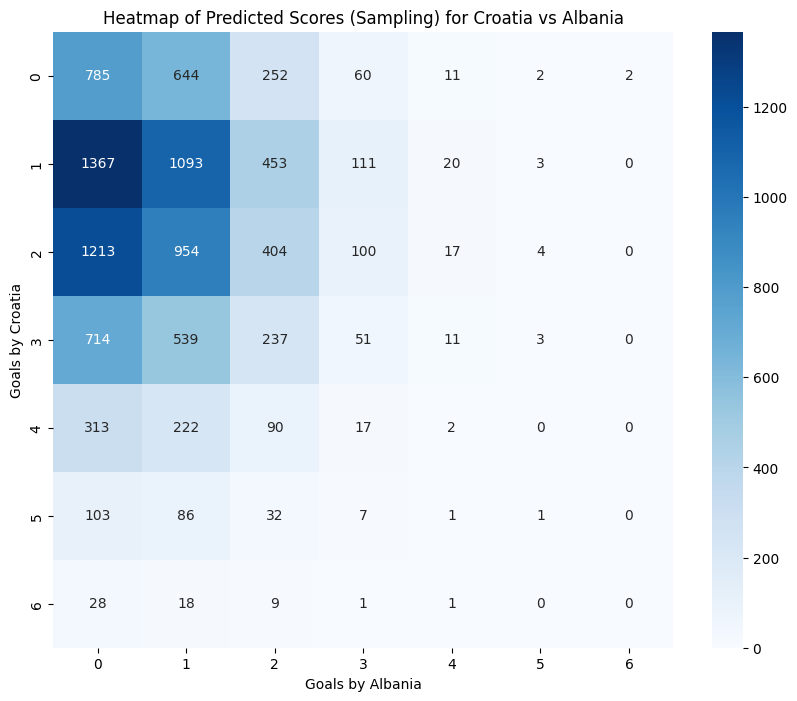

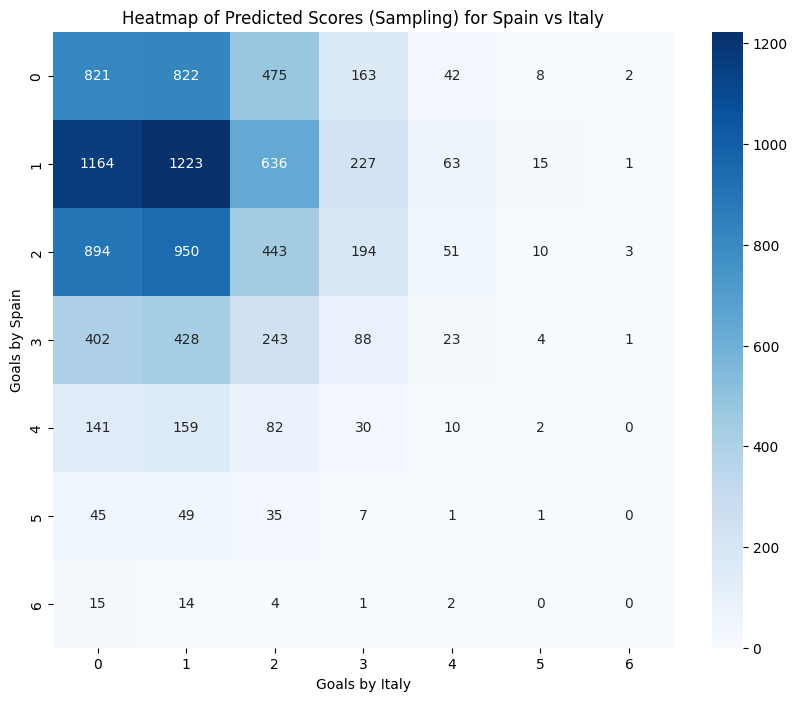

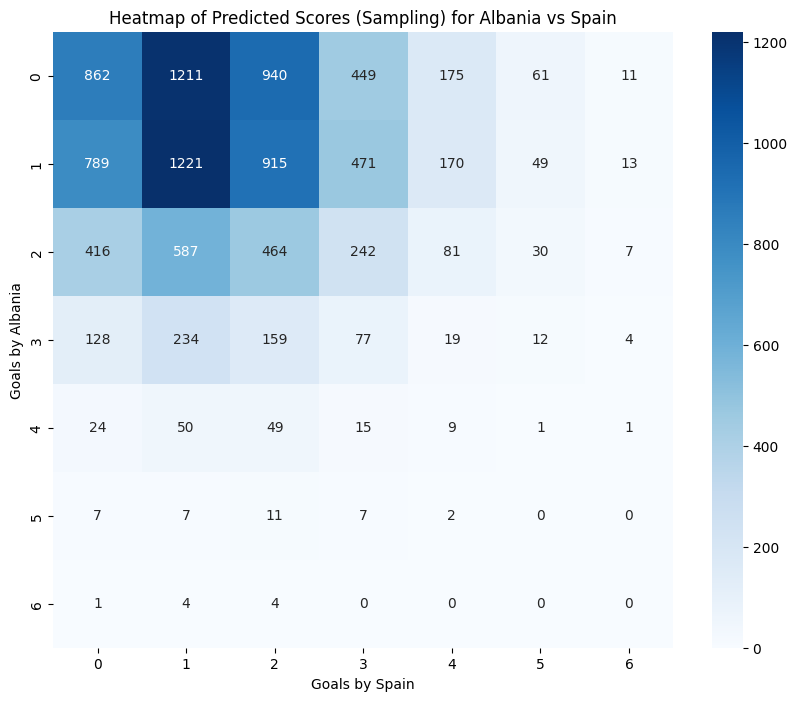

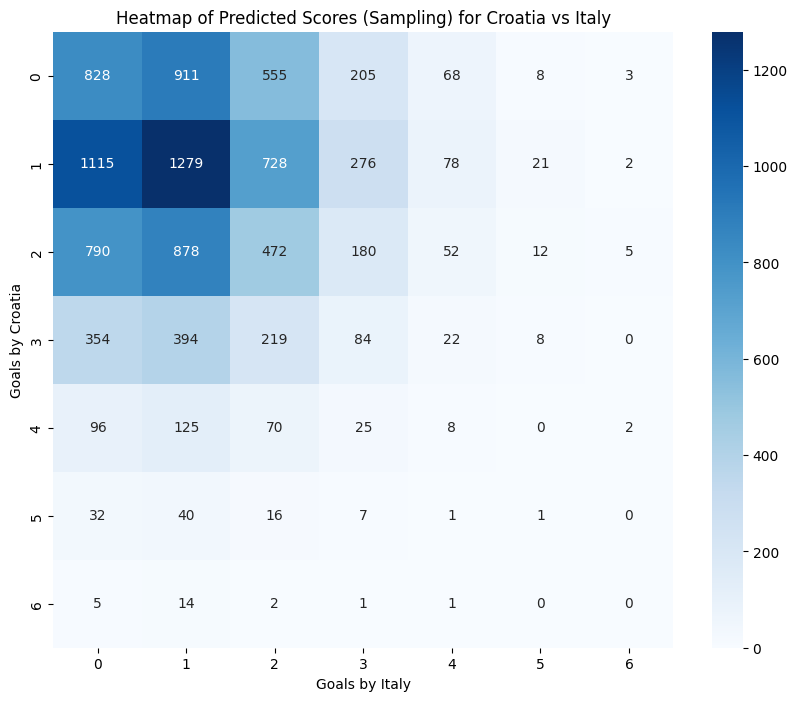

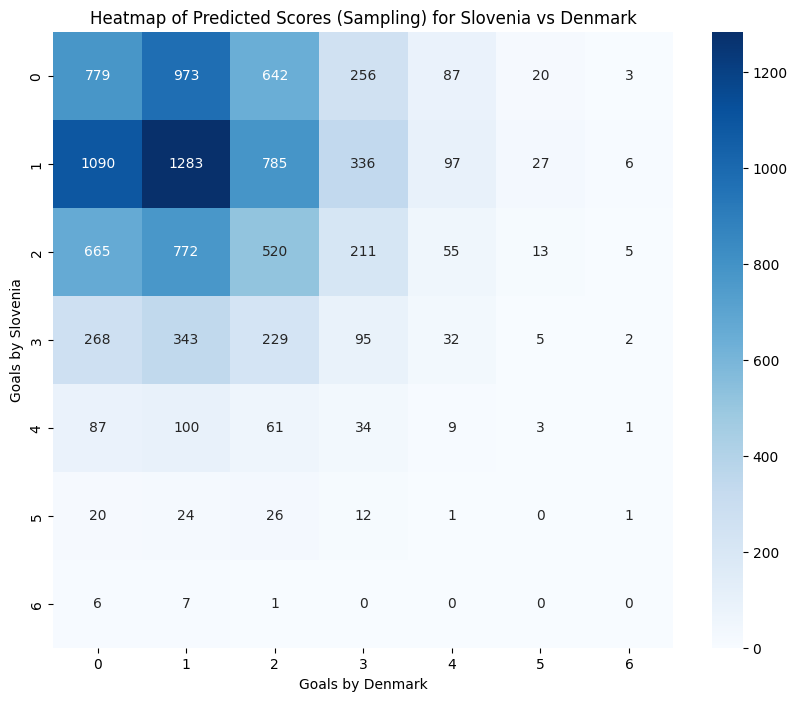

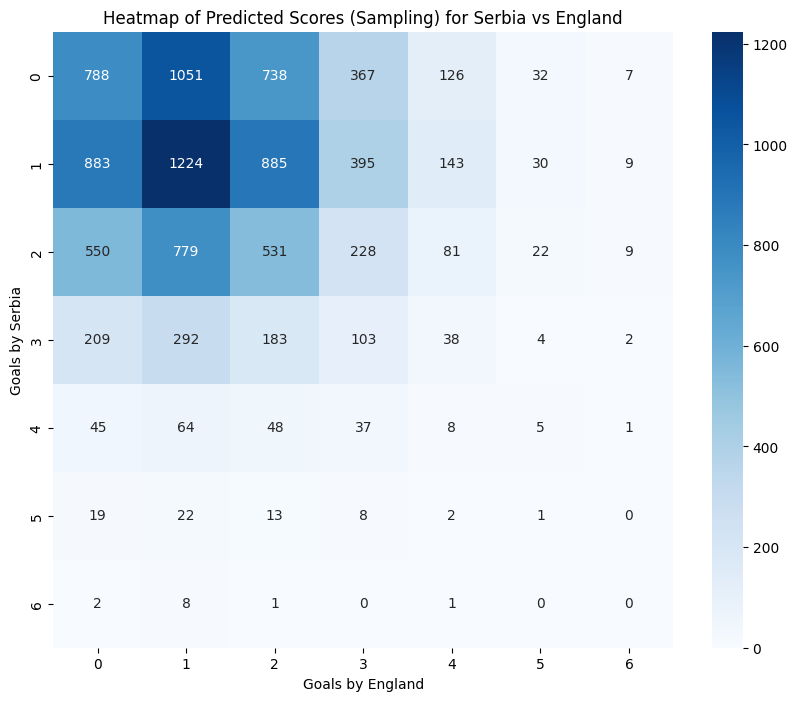

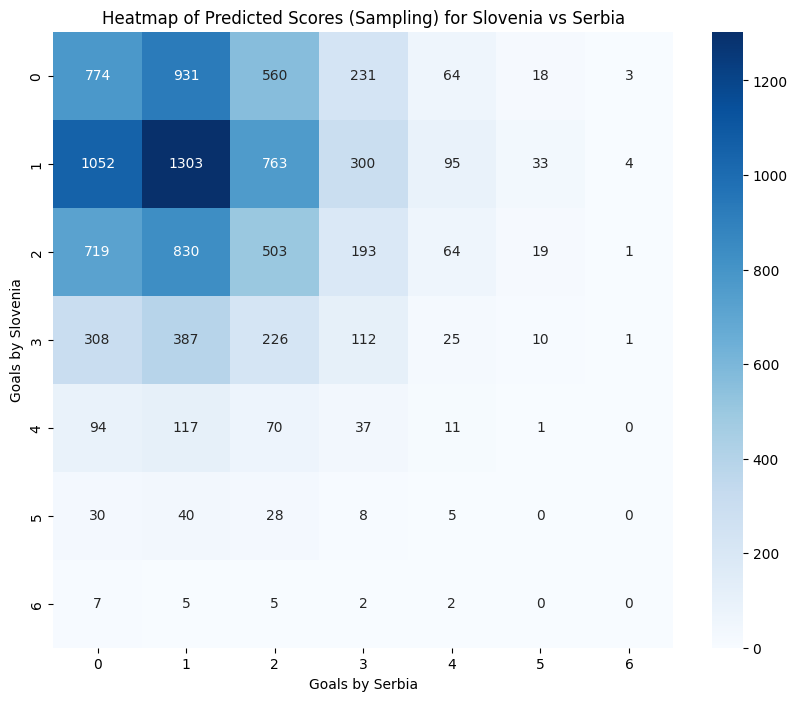

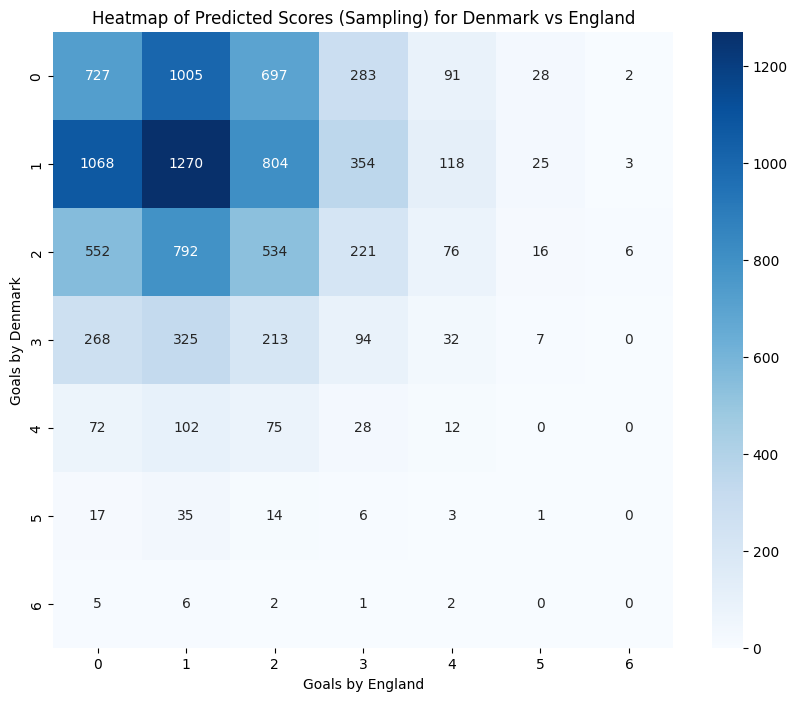

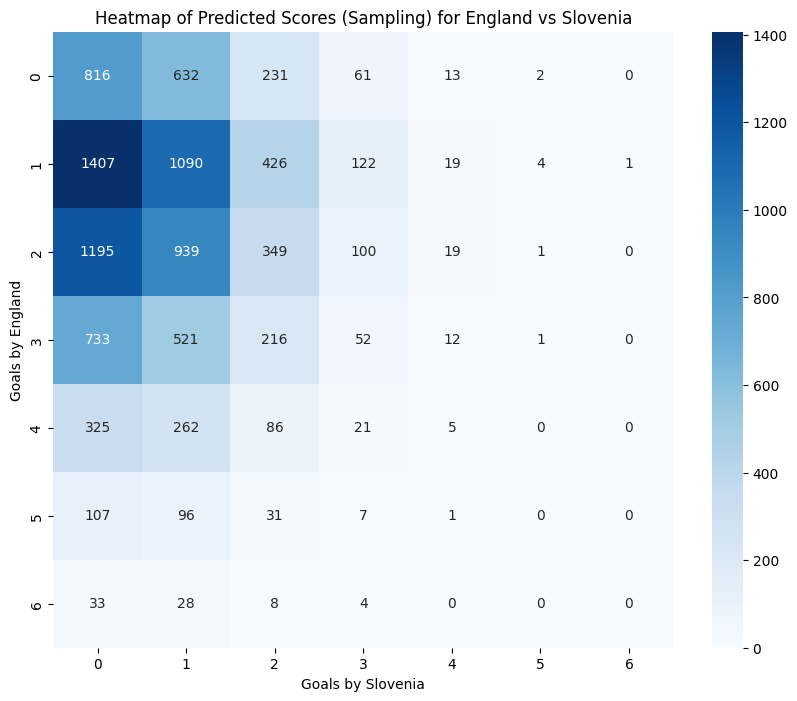

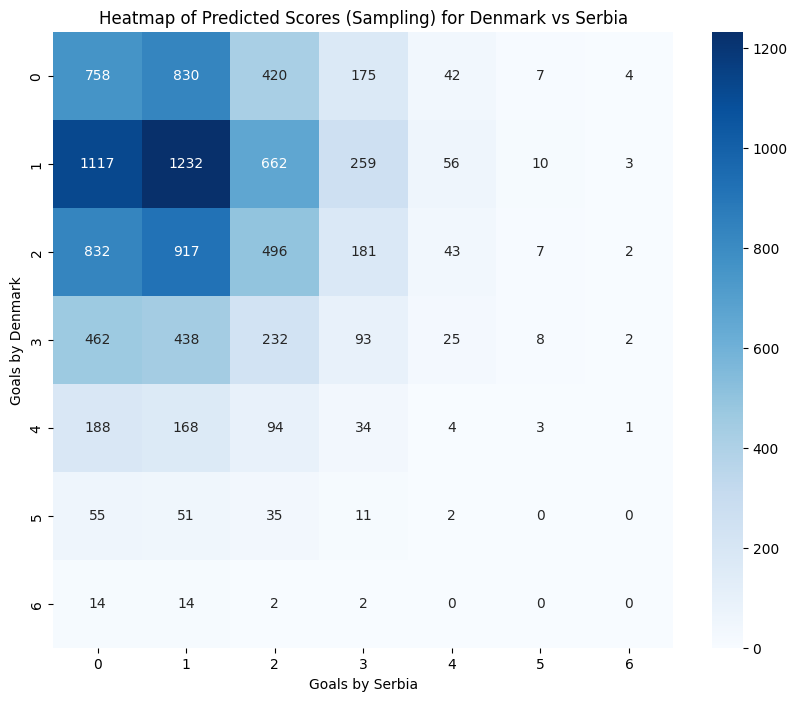

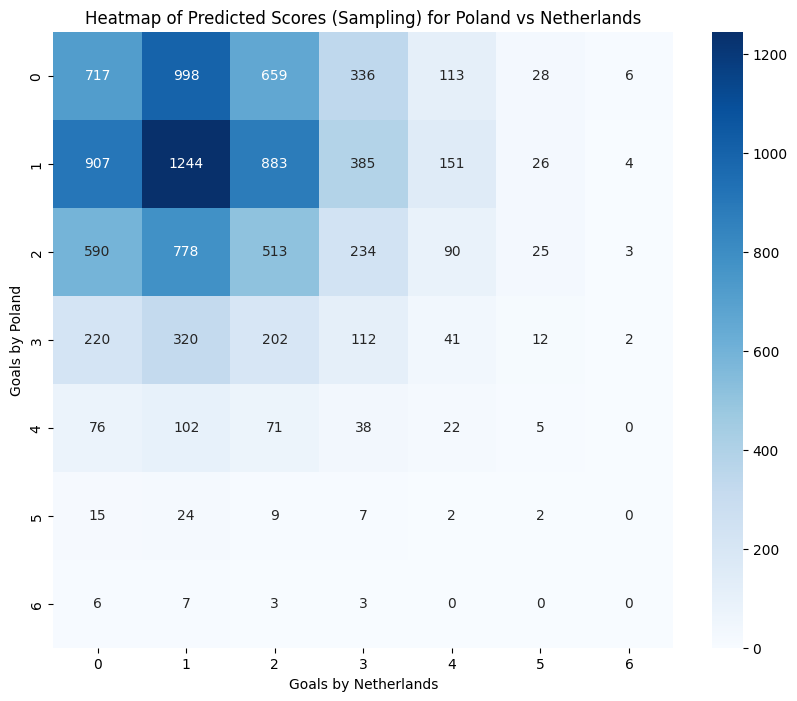

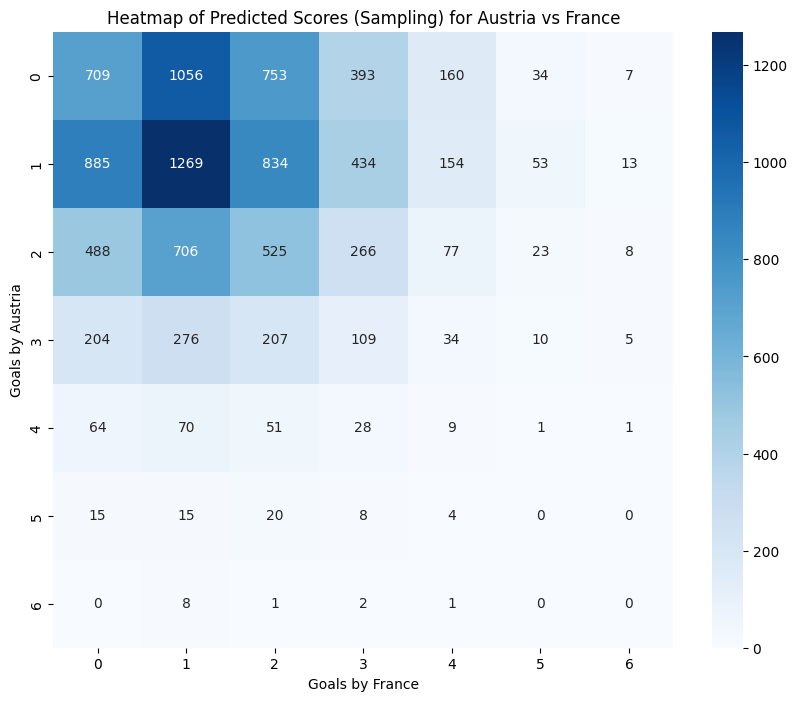

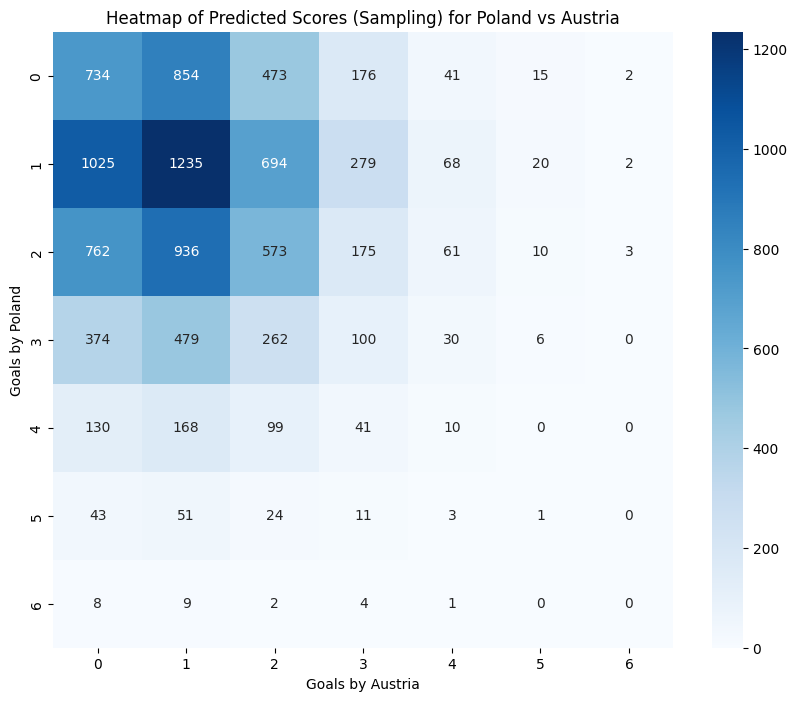

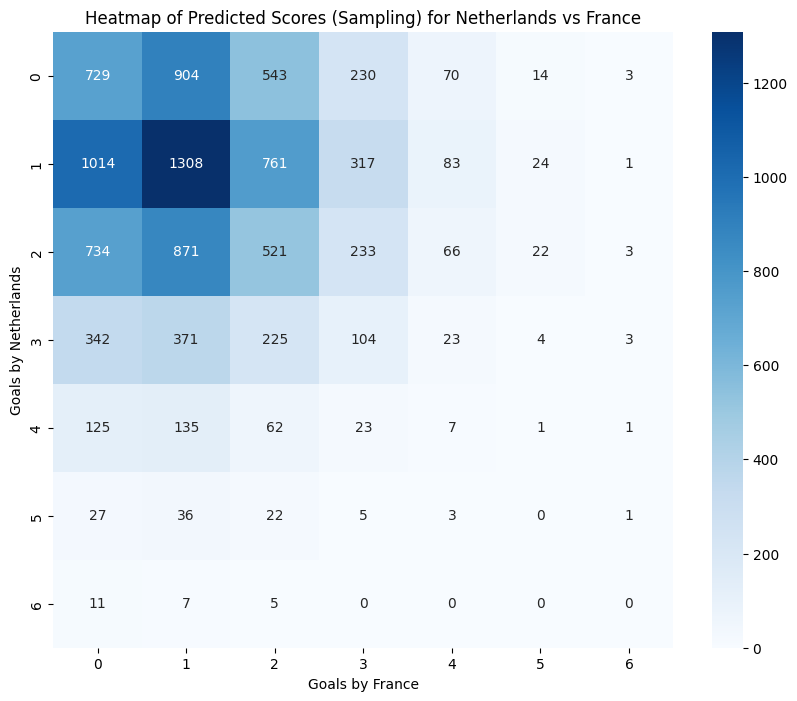

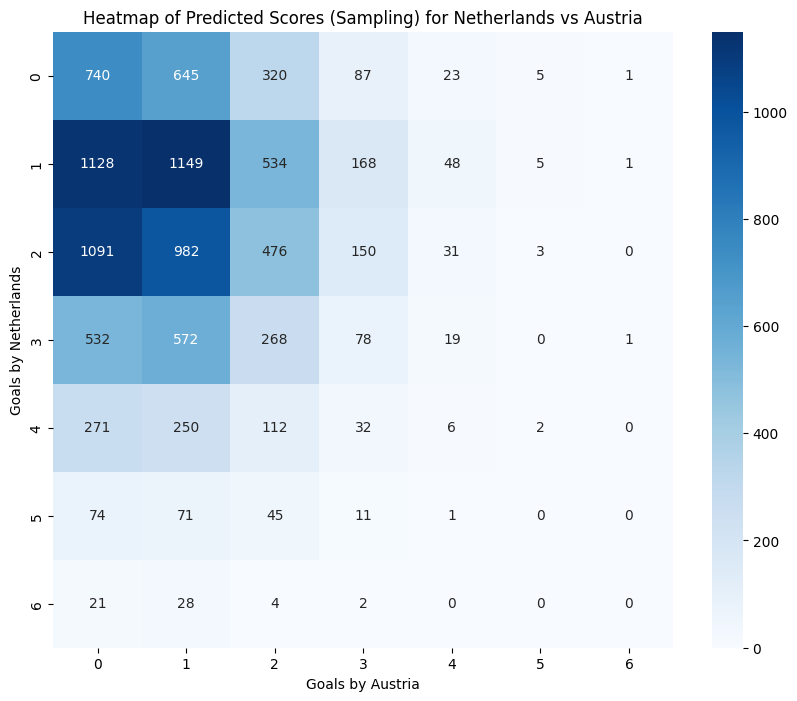

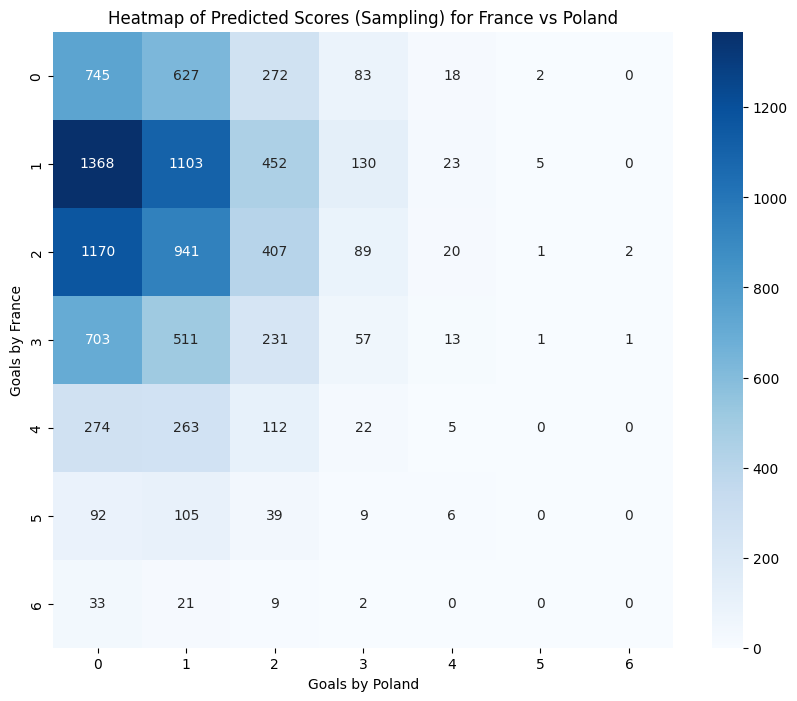

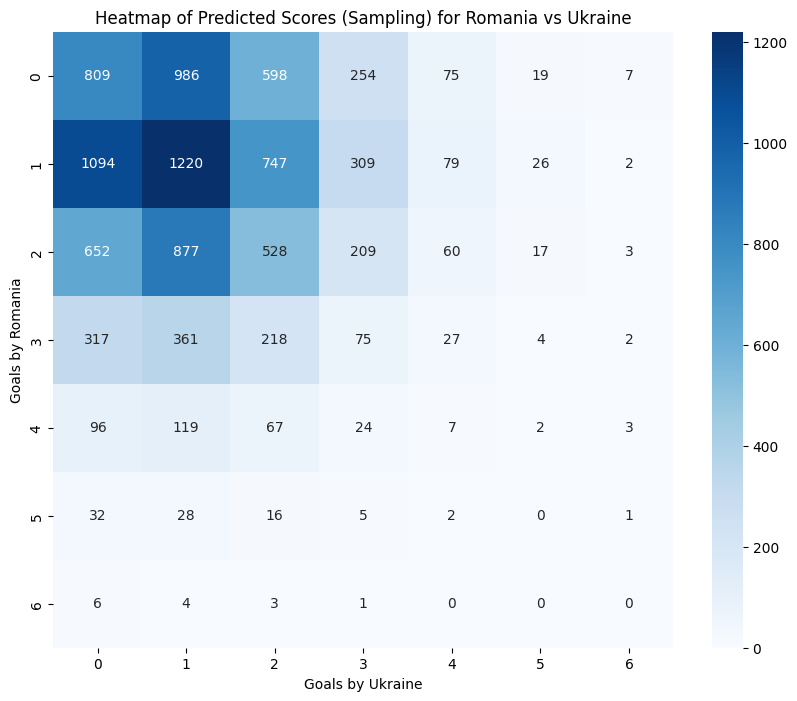

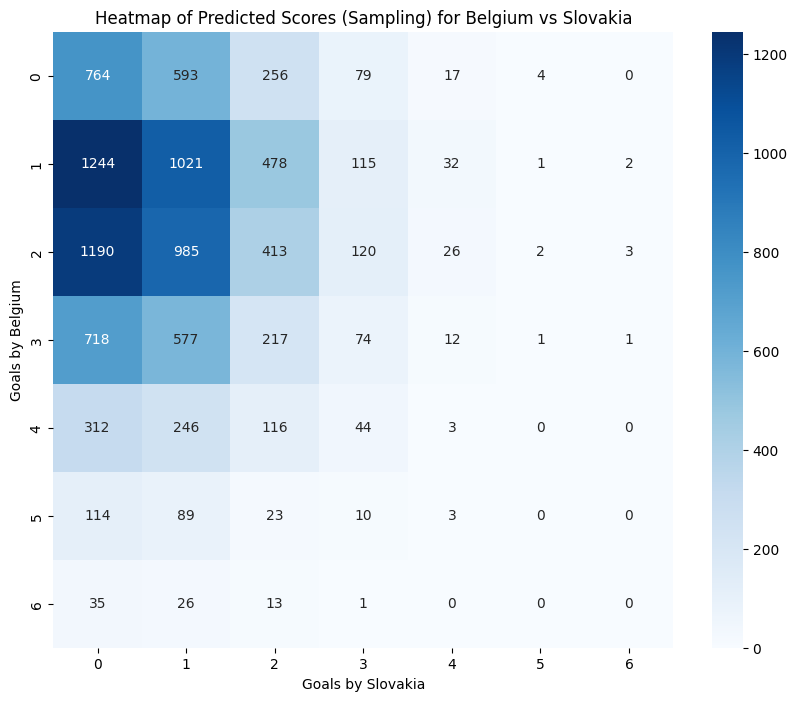

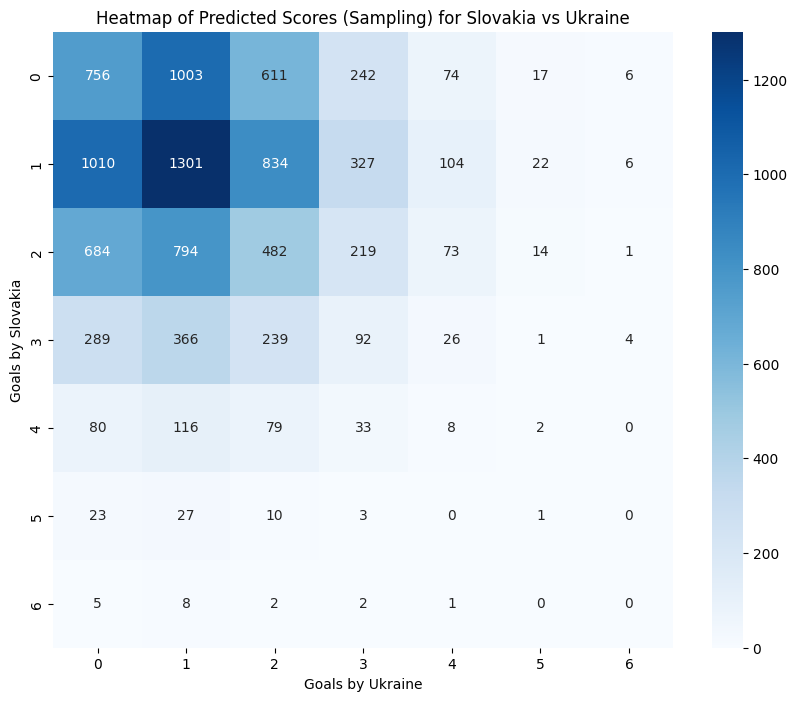

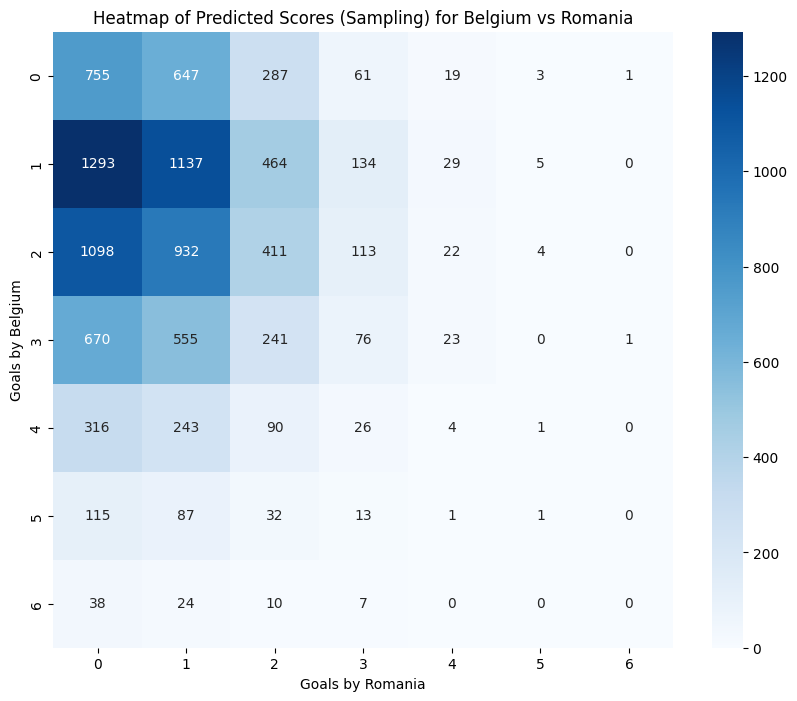

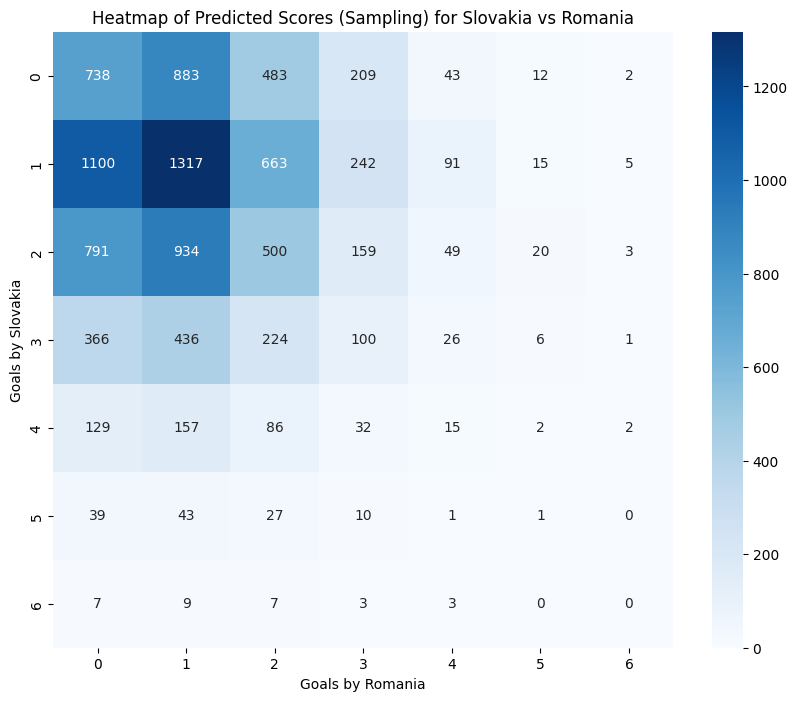

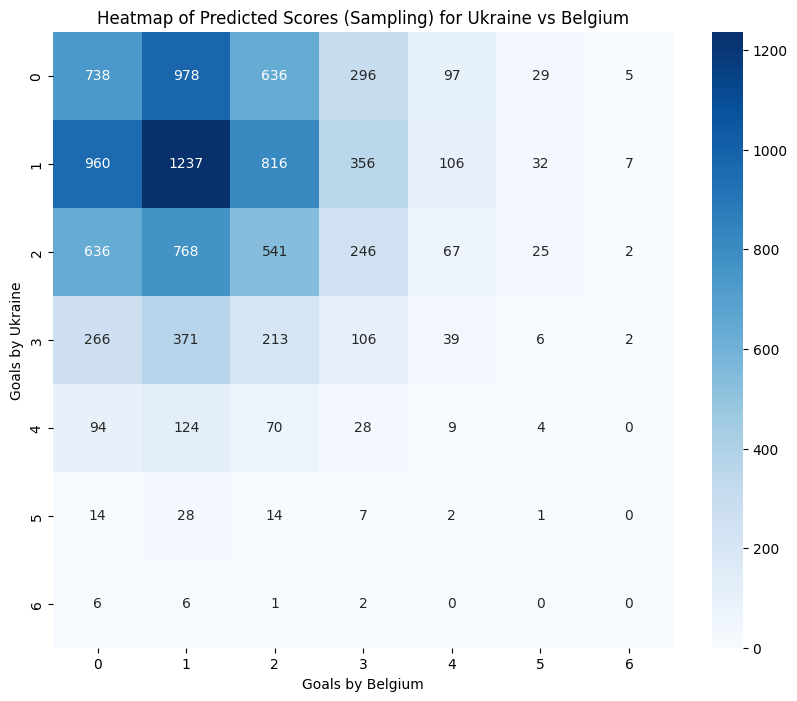

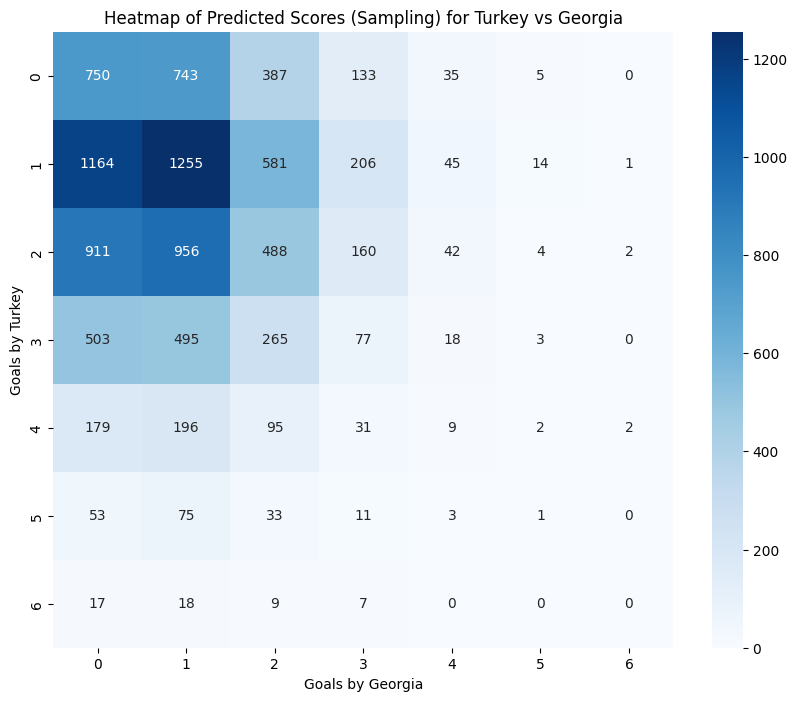

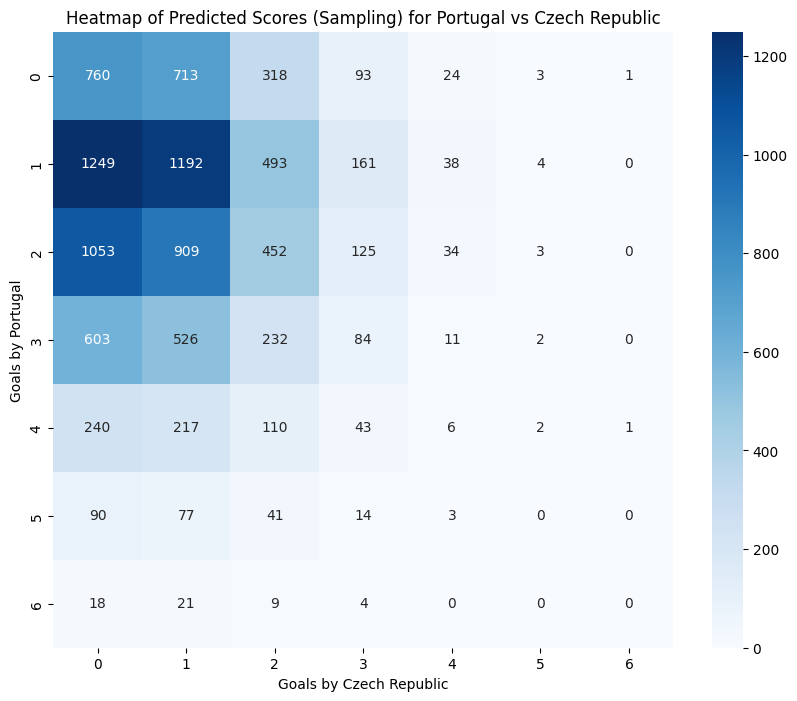

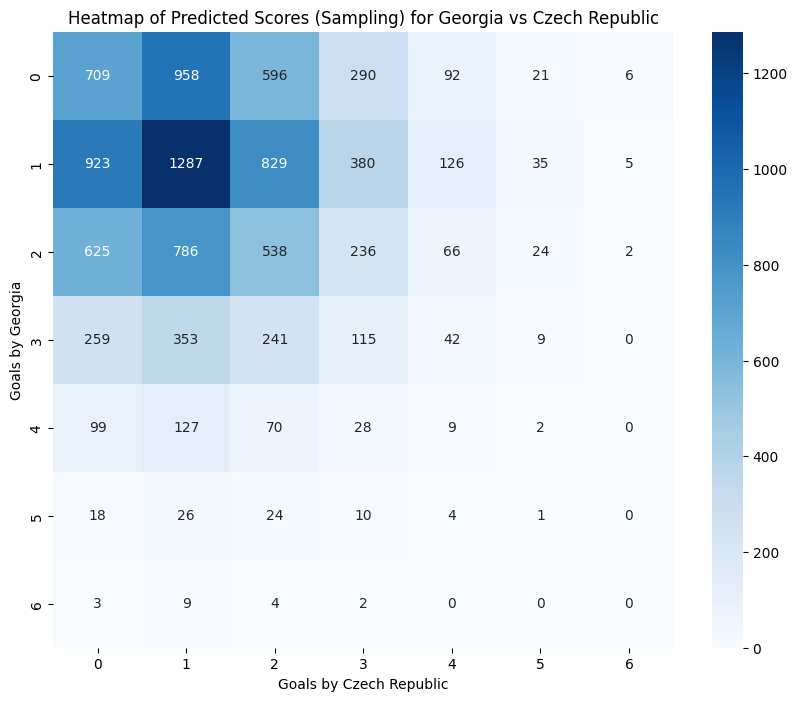

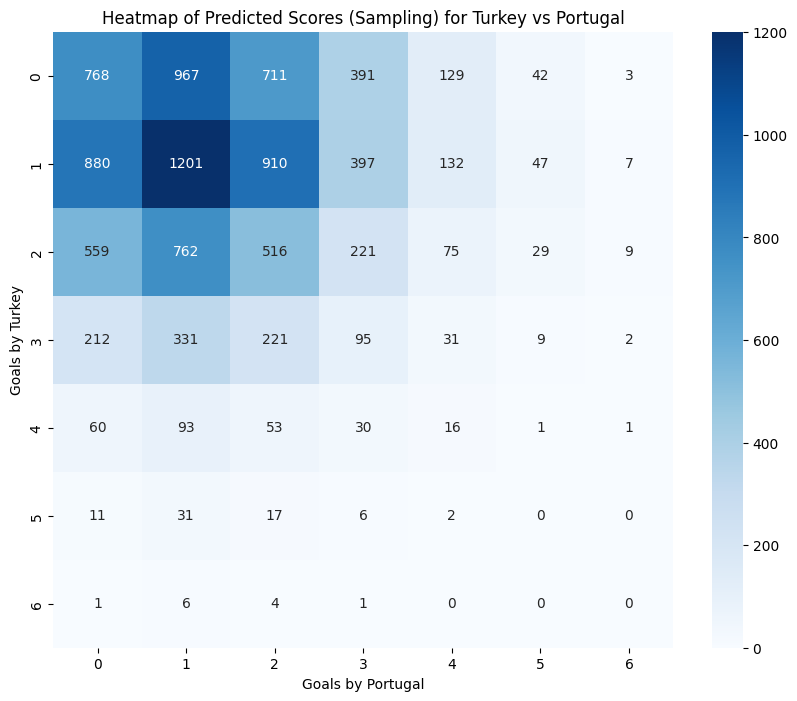

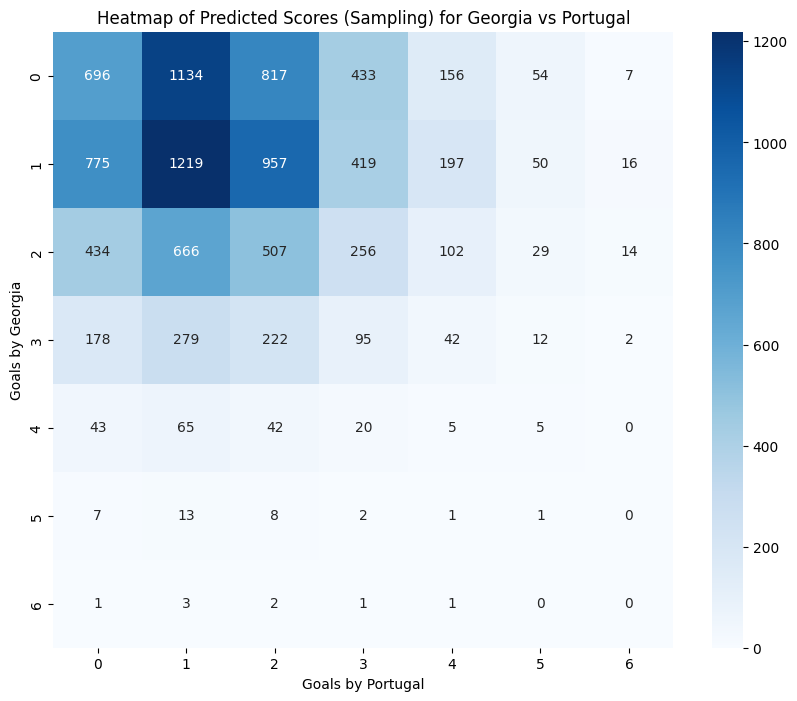

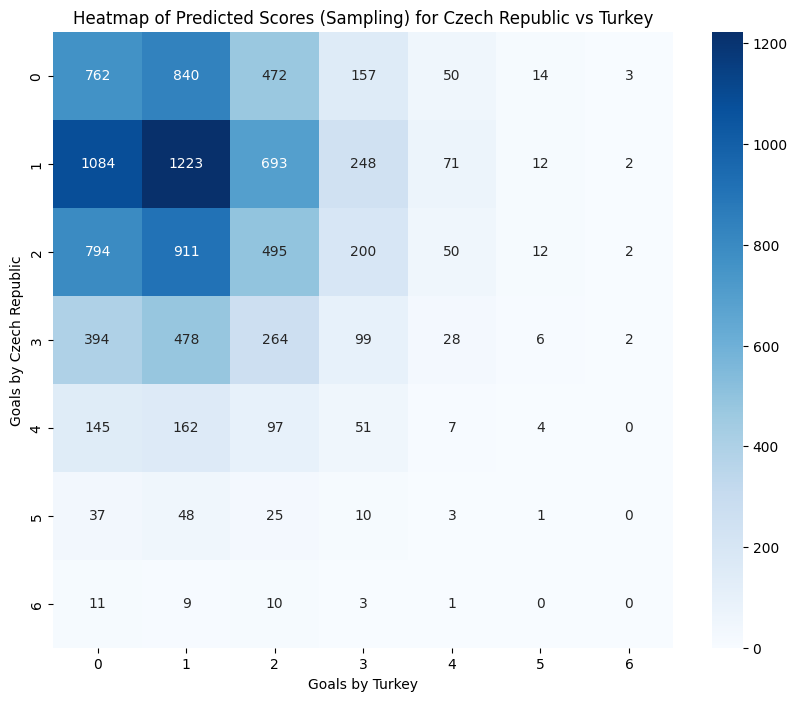

In [53]:
for match in matches_data:
    home_team = match["Home_Team"]
    away_team = match["Away_Team"]
    xG_home, xG_away = predict_match_xG(home_team, away_team)
    generate_heatmap_sampling(home_team, away_team, xG_home, xG_away)

In [59]:
def predict_score(home_team, away_team):
    xG_home, xG_away = predict_match_xG(home_team, away_team)
    home_goals = np.round(sample_poiss(xG_home, 1))
    away_goals = np.round(sample_poiss(xG_away, 1))
    return home_goals[0], away_goals[0]

for match in matches_data:
    home_team = match["Home_Team"]
    away_team = match["Away_Team"]
    home_goals, away_goals = predict_score(home_team, away_team)
    print(home_team, home_goals, '-', away_goals, away_team)

Germany 2 - 2 Scotland
Hungary 1 - 2 Switzerland
Germany 3 - 1 Hungary
Scotland 1 - 1 Switzerland
Switzerland 6 - 0 Germany
Scotland 0 - 2 Hungary
Spain 0 - 2 Croatia
Italy 2 - 0 Albania
Croatia 1 - 1 Albania
Spain 0 - 1 Italy
Albania 0 - 3 Spain
Croatia 0 - 0 Italy
Slovenia 0 - 0 Denmark
Serbia 1 - 0 England
Slovenia 2 - 0 Serbia
Denmark 2 - 1 England
England 4 - 0 Slovenia
Denmark 4 - 7 Serbia
Poland 1 - 0 Netherlands
Austria 0 - 1 France
Poland 2 - 1 Austria
Netherlands 3 - 1 France
Netherlands 2 - 1 Austria
France 0 - 2 Poland
Romania 0 - 3 Ukraine
Belgium 3 - 0 Slovakia
Slovakia 0 - 1 Ukraine
Belgium 1 - 0 Romania
Slovakia 1 - 3 Romania
Ukraine 3 - 3 Belgium
Turkey 2 - 1 Georgia
Portugal 2 - 2 Czech Republic
Georgia 1 - 3 Czech Republic
Turkey 1 - 1 Portugal
Georgia 0 - 0 Portugal
Czech Republic 3 - 2 Turkey


In [82]:
def simulate_group_stage(matches_df):
    groups = matches_df['Grupo'].unique()
    results = {group: {} for group in groups}
    
    for group in groups:
        group_matches = matches_df[matches_df['Grupo'] == group]
        
        for _, match in group_matches.iterrows():
            home_team = match['Home_Team']
            away_team = match['Away_Team']
            home_goals, away_goals = predict_score(home_team, away_team)
            
            if home_team not in results[group]:
                results[group][home_team] = {'points': 0, 'goals_for': 0, 'goals_against': 0}
            if away_team not in results[group]:
                results[group][away_team] = {'points': 0, 'goals_for': 0, 'goals_against': 0}
            
            results[group][home_team]['goals_for'] += home_goals
            results[group][home_team]['goals_against'] += away_goals
            results[group][away_team]['goals_for'] += away_goals
            results[group][away_team]['goals_against'] += home_goals
            
            if home_goals > away_goals:
                results[group][home_team]['points'] += 3
            elif home_goals < away_goals:
                results[group][away_team]['points'] += 3
            else:
                results[group][home_team]['points'] += 1
                results[group][away_team]['points'] += 1
                
    return results

# Simulate 10 iterations
iterations = 10
all_results = []

for i in range(iterations):
    result = simulate_group_stage(matches_df)
    all_results.append(result)

# Display results of the last iteration as an example
final_standings = []

for group, teams in all_results[-1].items():
    group_standing = []
    for team, stats in teams.items():
        group_standing.append({
            'Team': team,
            'Points': stats['points'],
            'Goals_For': stats['goals_for'],
            'Goals_Against': stats['goals_against'],
            'Goal_Difference': stats['goals_for'] - stats['goals_against']
        })
    group_standing = sorted(group_standing, key=lambda x: (x['Points'], x['Goal_Difference']), reverse=True)
    final_standings.append(pd.DataFrame(group_standing))
# import ace_tools as tools; tools.display_dataframe_to_user(name="Final Standings after Last Simulation", dataframe=final_standings[-1])


In [83]:
final_standings

[          Team  Points  Goals_For  Goals_Against  Goal_Difference
 0     Scotland       6          6              3                3
 1      Germany       6          4              3                1
 2  Switzerland       6          6              6                0
 3      Hungary       0          4              8               -4,
       Team  Points  Goals_For  Goals_Against  Goal_Difference
 0    Italy       7          6              3                3
 1  Croatia       6          7              4                3
 2    Spain       4          3              5               -2
 3  Albania       0          2              6               -4,
        Team  Points  Goals_For  Goals_Against  Goal_Difference
 0  Slovenia       5          6              3                3
 1   England       5          4              3                1
 2    Serbia       2          1              2               -1
 3   Denmark       2          3              6               -3,
           Team  Points  Go

In [93]:
import pandas as pd

# Simulate group stage function
def simulate_group_stage_with_tracking(matches_df):
    groups = matches_df['Grupo'].unique()
    results = {group: {} for group in groups}
    
    for group in groups:
        group_matches = matches_df[matches_df['Grupo'] == group]
        
        for _, match in group_matches.iterrows():
            home_team = match['Home_Team']
            away_team = match['Away_Team']
            home_goals, away_goals = predict_score(home_team, away_team)
            
            if home_team not in results[group]:
                results[group][home_team] = {'points': 0, 'goals_for': 0, 'goals_against': 0}
            if away_team not in results[group]:
                results[group][away_team] = {'points': 0, 'goals_for': 0, 'goals_against': 0}
            
            results[group][home_team]['goals_for'] += home_goals
            results[group][home_team]['goals_against'] += away_goals
            results[group][away_team]['goals_for'] += away_goals
            results[group][away_team]['goals_against'] += home_goals
            
            if home_goals > away_goals:
                results[group][home_team]['points'] += 3
            elif home_goals < away_goals:
                results[group][away_team]['points'] += 3
            else:
                results[group][home_team]['points'] += 1
                results[group][away_team]['points'] += 1
                
    return results

# Initialize data structures to hold placement counts
placement_counts = {group: {} for group in matches_df['Grupo'].unique()}

# Simulate 10 iterations and collect data
iterations = 1000
all_results = []

for i in range(iterations):
    result = simulate_group_stage_with_tracking(matches_df)
    all_results.append(result)
    
    for group, teams in result.items():
        group_standing = []
        for team, stats in teams.items():
            group_standing.append({
                'Team': team,
                'Points': stats['points'],
                'Goals_For': stats['goals_for'],
                'Goals_Against': stats['goals_against'],
                'Goal_Difference': stats['goals_for'] - stats['goals_against']
            })
        group_standing = sorted(group_standing, key=lambda x: (x['Points'], x['Goal_Difference']), reverse=True)
        
        for position, team_data in enumerate(group_standing):
            team = team_data['Team']
            if team not in placement_counts[group]:
                placement_counts[group][team] = [0, 0, 0, 0]
            placement_counts[group][team][position] += 1

# Convert counts to percentages
placement_percentages = {group: {} for group in placement_counts.keys()}

for group, teams in placement_counts.items():
    for team, counts in teams.items():
        total_simulations = sum(counts)
        placement_percentages[group][team] = [count / total_simulations * 100 for count in counts]

# Display results of all iterations and final placement percentages
final_standings = []

for iteration, result in enumerate(all_results):
    iteration_standings = []
    for group, teams in result.items():
        group_standing = []
        for team, stats in teams.items():
            group_standing.append({
                'Team': team,
                'Points': stats['points'],
                'Goals_For': stats['goals_for'],
                'Goals_Against': stats['goals_against'],
                'Goal_Difference': stats['goals_for'] - stats['goals_against']
            })
        group_standing = sorted(group_standing, key=lambda x: (x['Points'], x['Goal_Difference']), reverse=True)
        iteration_standings.append(pd.DataFrame(group_standing))
    final_standings.append(iteration_standings)

# Print results of all iterations
for i, standings in enumerate(final_standings):
    for j, group_standing in enumerate(standings):
        group_name = f"Group {matches_df['Grupo'].unique()[j]} Standings after Iteration {i+1}"
        #print(group_name)
        #print(group_standing)
        #print("\n")

# Prepare placement percentages for display
placement_percentages_df = []

for group, teams in placement_percentages.items():
    for team, percentages in teams.items():
        placement_percentages_df.append({
            'Group': group,
            'Team': team,
            '1st Place %': percentages[0],
            '2nd Place %': percentages[1],
            '3rd Place %': percentages[2],
            '4th Place %': percentages[3]
        })

placement_percentages_df = pd.DataFrame(placement_percentages_df)

# Display separate tables for each group, sorted by percentages
groups = placement_percentages_df['Group'].unique()

for group in groups:
    group_df = placement_percentages_df[placement_percentages_df['Group'] == group]
    group_df = group_df.sort_values(by=['1st Place %', '2nd Place %', '3rd Place %'], ascending=False).reset_index(drop=True)
    print(f"Placement Percentages for Group {group}")
    print(group_df)
    print("\n")




Placement Percentages for Group A
  Group         Team  1st Place %  2nd Place %  3rd Place %  4th Place %
0     A      Germany         39.9         26.4         20.2         13.5
1     A     Scotland         21.7         24.4         27.3         26.6
2     A  Switzerland         20.4         26.7         22.6         30.3
3     A      Hungary         18.0         22.5         29.9         29.6


Placement Percentages for Group B
  Group     Team  1st Place %  2nd Place %  3rd Place %  4th Place %
0     B    Spain         39.4         29.2         19.2         12.2
1     B  Croatia         29.2         28.7         27.9         14.2
2     B    Italy         26.0         28.7         28.8         16.5
3     B  Albania          5.4         13.4         24.1         57.1


Placement Percentages for Group C
  Group      Team  1st Place %  2nd Place %  3rd Place %  4th Place %
0     C   England         37.3         28.4         19.0         15.3
1     C   Denmark         28.0         28.9 